In [1]:
import os
import sys

In [2]:
os.getcwd()
sys.path.append("../rfgi")

In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from mpl_toolkits.mplot3d import Axes3D

# from CARTGV import CARTGVTree, CARTGVTreeBuilder
# from CARTGV import CARTGVSplitter, BaseDenseCARTGVSplitter, BestCARTGVSplitter
# from CARTGV import CARTGVCriterion, CARTGVClassificationCriterion, CARTGVGini

from CARTGV_trees import DecisionCARTGVTreeClassifier, DecisionCARTGVTreeRegressor
from RFGV import RFGVClassifier, RFGVRegressor

from sklearn.utils.validation import check_random_state
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn.datasets import load_iris, load_diabetes, load_breast_cancer
from sklearn.model_selection import train_test_split

# Example 1 : Iris dataset and multi-classes classification

In this section we will have a simple example of the package. We will use the Iris dataset in a multi-classes classification problem.

# Data

We first load our data and create our groups.

In [4]:
#Loading of the data
data = load_iris()

X = data.data
y= data.target

#Split the data into train and test samples
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Represent the groups as an array containing the indexes of the group column/variable inside the data
# Here on the iris dataset we chose to regroup :
# Sepal Length and Sepal Width : Group 0
# Petal Length and Petal Width : Group 1
# Sepal Length and Petal Length : Group 2
# Sepal Width and Petal Width : Group 3
groups = np.array([[0,1],[2,3],[0,2],[1,3]])

As you can see above, the groups are defined as array containing the indexes of the variables. One variables can be in multiple groups. 

In this example the groups were set by grouping the variables about the Sepal together, the Petal together and a mix with Sepal and Petal length and Sepal and Petal width.

# Data representation

We will now represent our datas, what compose our dataset and what we want to predict.

In [5]:
print(data.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

<ipython-input-6-432b36512c3e>:26: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


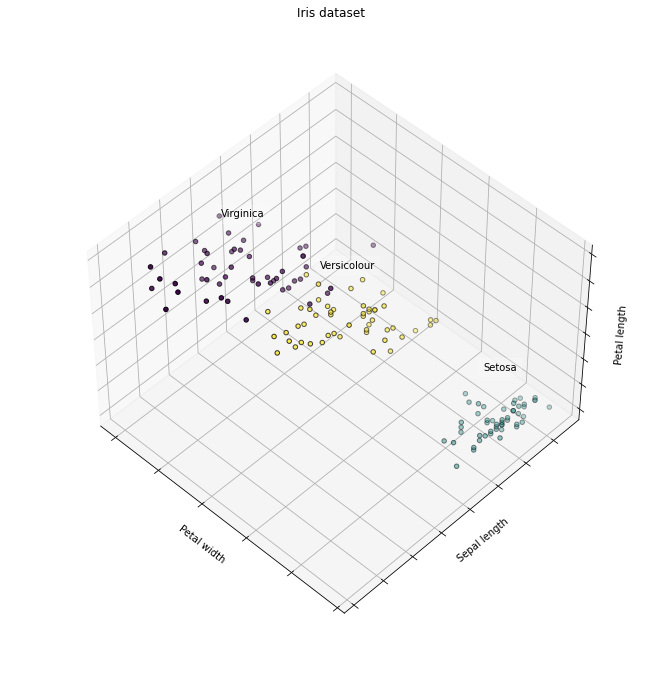

In [6]:
# Plot the data
fig = plt.figure(0, figsize=(16, 9))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

for name, label in [('Setosa', 0),
                    ('Versicolour', 1),
                    ('Virginica', 2)]:
    ax.text3D(X[y == label, 3].mean(),
              X[y == label, 0].mean(),
              X[y == label, 2].mean() + 2, name,
              horizontalalignment='center',
              bbox=dict(alpha=.2, edgecolor='w', facecolor='w'))
# Reorder the labels to have colors matching the cluster results
y_reordered = np.choose(y, [1, 2, 0]).astype(float)
ax.scatter(X[:, 3], X[:, 0], X[:, 2], c=y_reordered, edgecolor='k')

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('Petal width')
ax.set_ylabel('Sepal length')
ax.set_zlabel('Petal length')
ax.set_title('Iris dataset')
ax.dist = 12

fig.show()

On the figure above we can see the Iris dataset and it's representation.

We can see 3 of the 4 variables which are Petal Length, Sepal length, Petal Width and Sepal Width.

We can also see that the dataset is composed of 3 classes, Virginica, Versicolour and Setosa.

Moreover, in this representation, we cna see an important variable, Petal Width, that will split the dataset in the correct classes. We will later compare it to our result.

# Parameters

We will now define our parameter for our tree construction.

In [7]:
sample_size = X_train.shape[0]

len_groups = np.array([len(group) for group in groups])

min_samples_leaf = 1 # The minimum number of samples in a leaf
min_samples_split = 2 # The minimum number of samples needed to split the node
min_weight_leaf = 0 # The minimum weight in a leaf
random_state = 2547 # The seed
max_depth = None # The maximal depth for the splitting_tree
max_depth_splitting_tree = 2
mgroup = len(groups) # The number of group to visit
mvar = len_groups # The number of variable to visit
min_impurity_decrease = 0.0 # The minimum decrease in impurity that we want to achieve after a split
min_impurity_split = 0.0 # The minimum impurity under which the node is considered a leaf
min_impurity_decrease_splitting_tree = 0.0
min_impurity_split_splitting_tree = 0.0

## Objects construction

We create here the object that will represent our tree. We use our previous parameters to define how our tree will be constructed. 

Important to note, if we have max_depth_splitting_tree = 1 and our groups are composed only of one variable each and one for each variable, we will create a CART tree such as the DecisionTreeClassifier of Scikit-learn.

In [8]:
cartgvtreeclassifier = DecisionCARTGVTreeClassifier(mvar=mvar, 
                            mgroup=mgroup,
                            random_state=random_state, 
                            max_depth_splitting_tree=max_depth_splitting_tree)

## Tree construction

We construct our tree with our training datas and groups. After this our model will be trained and we will be able to predict, compute our classification score.

In [9]:
cartgvtreeclassifier.fit(X_train, y_train, groups)

DecisionCARTGVTreeClassifier(mgroup=4, mvar=array([2, 2, 2, 2]),
                             random_state=2547)

## Classification score

Here we compute our classification score with our test datas

In [10]:
cartgvtreeclassifier.score(X_test, y_test)

0.96

## Classification prediction

In [86]:
cartgvtreeclassifier.predict(X_test)

array([1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0,
       0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1,
       0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1])

# Results and visualisation

We can, in this section, see much more information about our tree. We will be able to see the impurity in each node, the number of samples, the group used to split and even the splitting tree will

## Parents
Each number represent the parent of the node with the id the index of the array.
The parent -2 represent the root

In [12]:
print(cartgvtreeclassifier.tree_.nodes_parent)

[-2.  0.  1.  1.  1.  0.  5.  5.  7.  7.  5. 10. 10. 10.  0.]


## Impurities
Each value is the value of the node with the id the index of the array

In [13]:
print(cartgvtreeclassifier.tree_.nodes_impurities)

[0.6658     0.06243496 0.         0.         0.         0.18836565
 0.         0.5        0.         0.         0.05709343 0.
 0.         0.         0.        ]


## Number of samples in each node

In [14]:
print(cartgvtreeclassifier.tree_.nodes_n_node_samples)
print('\n')
print(cartgvtreeclassifier.tree_.nodes_weighted_n_node_samples)

[100.  31.  28.   2.   1.  38.   2.   2.   1.   1.  34.  31.   1.   2.
  31.]


[100.  31.  28.   2.   1.  38.   2.   2.   1.   1.  34.  31.   1.   2.
  31.]


## Groups
Represent the group that splited the node.
A value of -1 means the node is a leaf and wasn't splitted.

In [15]:
print(cartgvtreeclassifier.tree_.nodes_group)

[ 1.  2. -2. -2. -2.  1. -2.  1. -2. -2.  3. -2. -2. -2. -2.]


## Number of childs

In [16]:
print(cartgvtreeclassifier.tree_.nodes_n_childs)

[3. 3. 0. 0. 0. 3. 0. 2. 0. 0. 3. 0. 0. 0. 0.]


## Number of nodes in the CARTGVTree

In [17]:
print(cartgvtreeclassifier.tree_.node_count)

15


## Splitting trees
In order of split

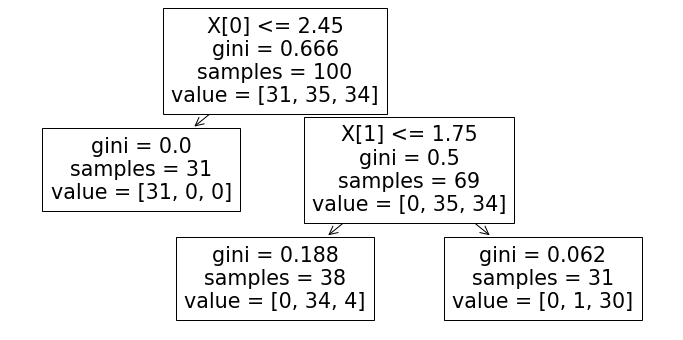

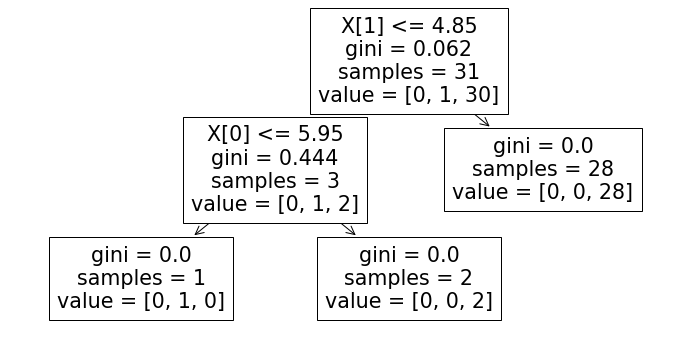

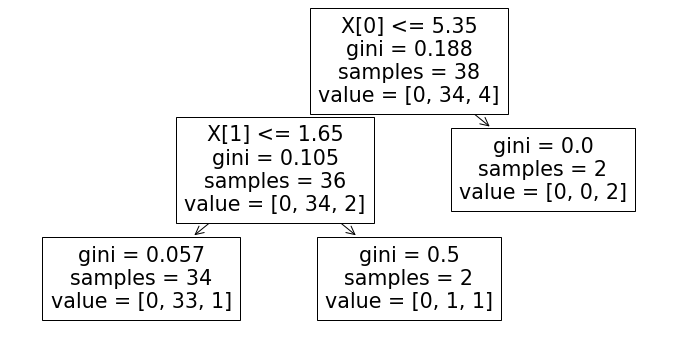

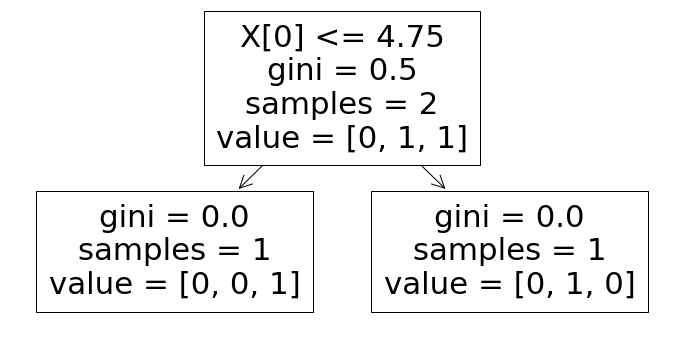

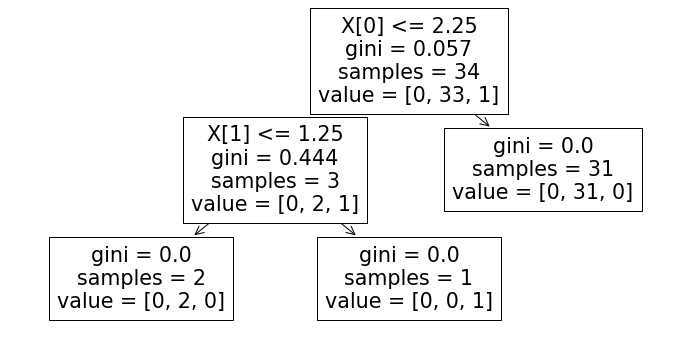

In [18]:
clf = DecisionTreeClassifier(max_depth=max_depth, random_state=random_state, max_features=len(groups[0]),
                             max_leaf_nodes=X.shape[0])

for i in range(cartgvtreeclassifier.tree_.node_count):
    clf.tree_ = cartgvtreeclassifier.tree_.nodes_splitting_trees[i]
    if(cartgvtreeclassifier.tree_.nodes_splitting_trees[i] != None):
        fig, ax = plt.subplots(1, figsize=(12, 6))
        plot_tree(clf)
        plt.show()

# Example 2 : Diabetes dataset and regression

In [57]:
#Loading of the data
data = load_diabetes()
X = data.data
y = data.target

#Split the data into train and test samples
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Represent the groups as an array containing the indexes of the group column/variable inside the data
# Here on the iris dataset we chose to regroup :
# Sepal Length and Sepal Width : Group 0
# Petal Length and Petal Width : Group 1
# Sepal Length and Petal Length : Group 2
# Sepal Width and Petal Width : Group 3
groups = np.array([[2,9],[5,6],[0,1,2],[7,8],[4,8]], dtype=object)
# groups = np.array([[0],[1],[2],[3],[4],[5],[6],[7],[8],[9]])

In [58]:
print(data.DESCR)

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, T-Cells (a type of white blood cells)
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, thyroid stimulating hormone
      - s5      ltg, lamotrigine
      - s6      glu, blood sugar level

Note: Each of these 10 feature va

## Parameters

In [59]:
sample_size = X_train.shape[0]

len_groups = np.array([len(group) for group in groups])

# ys = np.atleast_1d(y_train)
min_samples_leaf = 1 # The minimum number of samples in a leaf
min_samples_split = 2 # The minimum number of samples needed to split the node
min_weight_leaf = 0 # The minimum weight in a leaf
random_state = 2547 # The seed
max_depth = None # The maximal depth for the splitting_tree
max_depth_splitting_tree = 2
mgroup = len(groups) # The number of group to visit
mvar = len_groups # The number of variable to visit
min_impurity_decrease = 0.0 # The minimum decrease in impurity that we want to achieve after a split
min_impurity_split = 0.0 # The minimum impurity under which the node is considered a leaf
min_impurity_decrease_splitting_tree = 0.0
min_impurity_split_splitting_tree = 0.0

## Object construction

In [60]:
cartgvtreeregressor = DecisionCARTGVTreeRegressor(mvar=mvar, 
                            mgroup=mgroup,
                            random_state=random_state, 
                            max_depth_splitting_tree=max_depth_splitting_tree)

## Tree construction

In [61]:
cartgvtreeregressor.fit(X_train, y_train, groups)

DecisionCARTGVTreeRegressor(mgroup=5, mvar=array([2, 2, 3, 2, 2]),
                            random_state=2547)

## Regression score

In [62]:
cartgvtreeregressor.score(X_test, y_test)

-0.1802735135367779

In [63]:
reg = DecisionTreeRegressor()
reg.fit(X_train, y_train)
reg.score(X_test, y_test)

-0.15808892336365

## Result and visualisation

### Parents

In [28]:
print(cartgvtreeregressor.tree_.nodes_parent)

[ -2.   0.   1.   2.   2.   2.   5.   5.   2.   8.   8.   1.   1.  12.
  12.  12.  12.   1.  17.  18.  18.  17.  21.  21.  21.  17.  25.  25.
  25.  17.  29.  29.   0.  32.  33.  34.  34.  36.  36.  34.  39.  39.
  34.  42.  42.  42.  33.  46.  46.  48.  48.  46.  51.  51.  46.  54.
  54.  33.  32.  58.  59.  59.  58.  58.  63.  64.  65.  65.  64.  68.
  68.  68.  68.  64.  73.  73.  73.  73.  64.  78.  78.  63.  81.  81.
  81.  81.  63.  63.  87.  87.  58.  90.  90.  90.  90.  94.  94.  32.
  97.  98.  98. 100. 100.  98.  98. 104. 104.  97. 107. 108. 108. 108.
 108. 107. 113. 114. 114. 113. 117. 117. 113. 113. 107. 107.  97.  97.
 125. 126. 126. 126. 125. 130. 130. 130. 125. 134. 134. 125. 137. 137.
 139. 139. 137.  32. 143. 144. 144. 144. 147. 147. 144. 143. 151. 151.
 151. 143. 155. 155. 155. 143. 159. 159.   0. 162. 163. 163. 165. 165.
 163. 163. 169. 169. 162. 172. 172. 174. 175. 175. 174. 174. 179. 179.
 174. 172. 183. 183. 183. 172. 187. 188. 189. 189. 188. 188. 188. 194.
 194. 

### Impurities

In [29]:
print(cartgvtreeregressor.tree_.nodes_impurities)

[6.01594904e+03 2.79756198e+03 1.85580556e+03 0.00000000e+00
 0.00000000e+00 2.50000000e+01 0.00000000e+00 0.00000000e+00
 1.00000000e+02 0.00000000e+00 0.00000000e+00 0.00000000e+00
 6.86875000e+01 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 8.18000000e+02 1.00000000e+00 0.00000000e+00
 0.00000000e+00 4.27500000e+01 0.00000000e+00 0.00000000e+00
 0.00000000e+00 3.46666667e+01 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00000000e+02 0.00000000e+00 0.00000000e+00
 4.25725961e+03 1.63768359e+03 3.98609375e+02 0.00000000e+00
 2.25000000e+00 0.00000000e+00 0.00000000e+00 9.00000000e+00
 0.00000000e+00 0.00000000e+00 7.35555556e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 7.57142857e+02 0.00000000e+00
 2.50000000e-01 0.00000000e+00 0.00000000e+00 1.22500000e+01
 0.00000000e+00 0.00000000e+00 1.82250000e+02 0.00000000e+00
 0.00000000e+00 0.00000000e+00 3.97908916e+03 2.40250000e+02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.02040997e+03
 2.46407639e+03 8.100000

### Number of samples in each nodes

In [30]:
print(cartgvtreeregressor.tree_.nodes_n_node_samples)
print('\n')
print(cartgvtreeregressor.tree_.nodes_weighted_n_node_samples)

[296.  22.   6.   1.   1.   2.   1.   1.   2.   1.   1.   1.   4.   1.
   1.   1.   1.  11.   2.   1.   1.   4.   1.   1.   2.   3.   1.   1.
   1.   2.   1.   1.  87.  16.   8.   1.   2.   1.   1.   2.   1.   1.
   3.   1.   1.   1.   7.   1.   2.   1.   1.   2.   1.   1.   2.   1.
   1.   1.  27.   2.   1.   1.   1.  19.  12.   2.   1.   1.   4.   1.
   1.   1.   1.   4.   1.   1.   1.   1.   2.   1.   1.   4.   1.   1.
   1.   1.   1.   2.   1.   1.   5.   1.   1.   1.   2.   1.   1.  31.
   6.   1.   2.   1.   1.   1.   2.   1.   1.  12.   4.   1.   1.   1.
   1.   6.   2.   1.   1.   2.   1.   1.   1.   1.   1.   1.   1.  12.
   3.   1.   1.   1.   3.   1.   1.   1.   2.   1.   1.   4.   1.   2.
   1.   1.   1.  13.   5.   1.   1.   2.   1.   1.   1.   3.   1.   1.
   1.   3.   1.   1.   1.   2.   1.   1.  79.   6.   1.   2.   1.   1.
   1.   2.   1.   1.  24.   1.   6.   2.   1.   1.   1.   2.   1.   1.
   1.   3.   1.   1.   1.  14.   6.   2.   1.   1.   1.   1.   2.   1.
   1. 

### Groups

In [31]:
print(cartgvtreeregressor.tree_.nodes_group)

[ 0.  1.  0. -2. -2.  3. -2. -2.  2. -2. -2. -2.  0. -2. -2. -2. -2.  4.
  0. -2. -2.  0. -2. -2. -2.  1. -2. -2. -2.  1. -2. -2.  4.  1.  4. -2.
  2. -2. -2.  1. -2. -2.  2. -2. -2. -2.  2. -2.  0. -2. -2.  0. -2. -2.
  0. -2. -2. -2.  4.  4. -2. -2. -2.  4.  0.  1. -2. -2.  1. -2. -2. -2.
 -2.  2. -2. -2. -2. -2.  4. -2. -2.  0. -2. -2. -2. -2. -2.  4. -2. -2.
  3. -2. -2. -2.  2. -2. -2.  1.  2. -2.  4. -2. -2. -2.  0. -2. -2.  2.
  0. -2. -2. -2. -2.  1.  0. -2. -2.  1. -2. -2. -2. -2. -2. -2. -2.  1.
  0. -2. -2. -2.  1. -2. -2. -2.  3. -2. -2.  1. -2.  0. -2. -2. -2.  2.
  4. -2. -2.  2. -2. -2. -2.  0. -2. -2. -2.  4. -2. -2. -2.  4. -2. -2.
  4.  2. -2.  4. -2. -2. -2.  0. -2. -2.  0. -2.  4.  0. -2. -2. -2.  4.
 -2. -2. -2.  0. -2. -2. -2.  1.  3.  4. -2. -2. -2. -2.  4. -2. -2.  2.
 -2. -2. -2. -2.  3. -2. -2. -2. -2.  1. -2.  4. -2.  4. -2.  0. -2. -2.
 -2. -2. -2.  4.  4. -2. -2.  4. -2. -2. -2.  2. -2.  2. -2. -2.  4. -2.
 -2.  2. -2. -2.  2.  1. -2. -2. -2.  2. -2. -2. -2

### Number of children

In [32]:
print(cartgvtreeregressor.tree_.nodes_n_childs)

[4. 4. 4. 0. 0. 2. 0. 0. 2. 0. 0. 0. 4. 0. 0. 0. 0. 4. 2. 0. 0. 3. 0. 0.
 0. 3. 0. 0. 0. 2. 0. 0. 4. 3. 4. 0. 2. 0. 0. 2. 0. 0. 3. 0. 0. 0. 4. 0.
 2. 0. 0. 2. 0. 0. 2. 0. 0. 0. 4. 2. 0. 0. 0. 4. 4. 2. 0. 0. 4. 0. 0. 0.
 0. 4. 0. 0. 0. 0. 2. 0. 0. 4. 0. 0. 0. 0. 0. 2. 0. 0. 4. 0. 0. 0. 2. 0.
 0. 4. 4. 0. 2. 0. 0. 0. 2. 0. 0. 4. 4. 0. 0. 0. 0. 4. 2. 0. 0. 2. 0. 0.
 0. 0. 0. 0. 0. 4. 3. 0. 0. 0. 3. 0. 0. 0. 2. 0. 0. 3. 0. 2. 0. 0. 0. 4.
 4. 0. 0. 2. 0. 0. 0. 3. 0. 0. 0. 3. 0. 0. 0. 2. 0. 0. 4. 4. 0. 2. 0. 0.
 0. 2. 0. 0. 4. 0. 4. 2. 0. 0. 0. 2. 0. 0. 0. 3. 0. 0. 0. 4. 4. 2. 0. 0.
 0. 0. 2. 0. 0. 4. 0. 0. 0. 0. 3. 0. 0. 0. 0. 4. 0. 4. 0. 4. 0. 3. 0. 0.
 0. 0. 0. 3. 2. 0. 0. 2. 0. 0. 0. 3. 0. 2. 0. 0. 2. 0. 0. 4. 0. 0. 4. 3.
 0. 0. 0. 2. 0. 0. 0. 3. 0. 0. 2. 0. 0. 3. 3. 0. 0. 0. 0. 0. 4. 0. 2. 0.
 0. 0. 0. 3. 2. 0. 0. 3. 0. 2. 0. 0. 0. 0. 4. 4. 0. 0. 4. 0. 0. 0. 0. 4.
 0. 0. 0. 0. 4. 4. 4. 4. 0. 0. 0. 2. 0. 0. 3. 0. 0. 0. 0. 0. 3. 0. 0. 0.
 4. 4. 0. 2. 0. 0. 0. 0. 3. 0. 0. 0. 0. 0. 3. 0. 0.

### Number of nodes in the tree

In [33]:
print(cartgvtreeregressor.tree_.node_count)

433


### Splitting trees

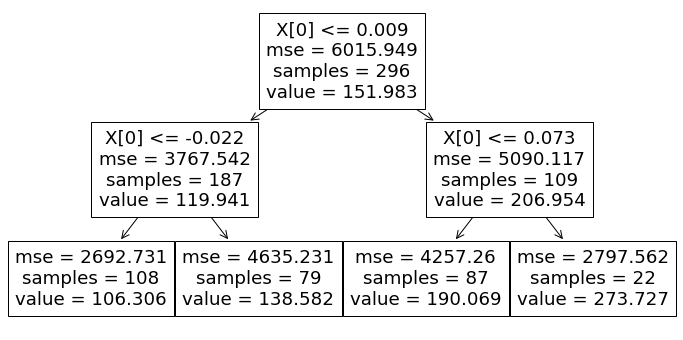

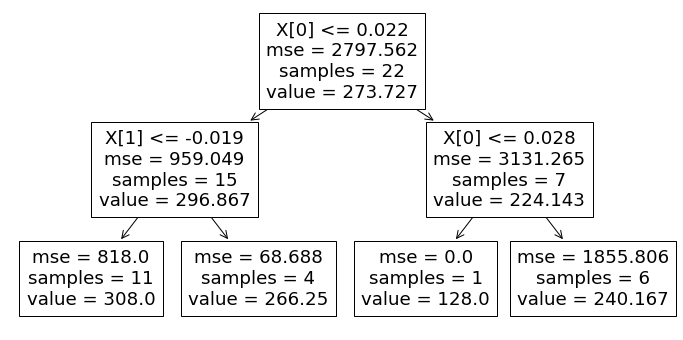

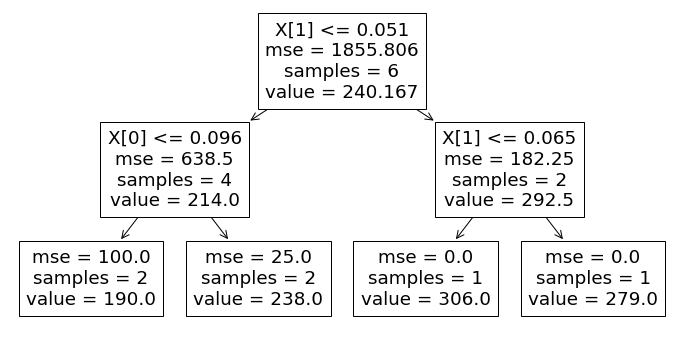

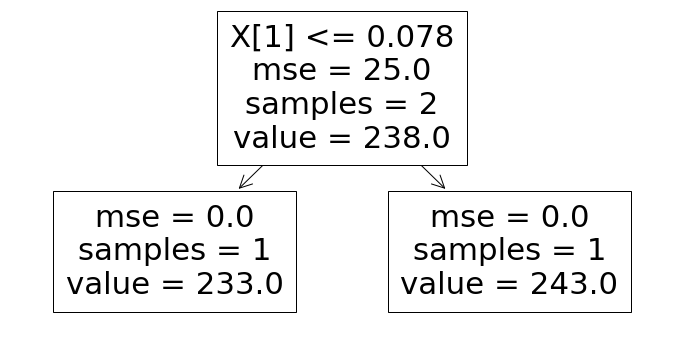

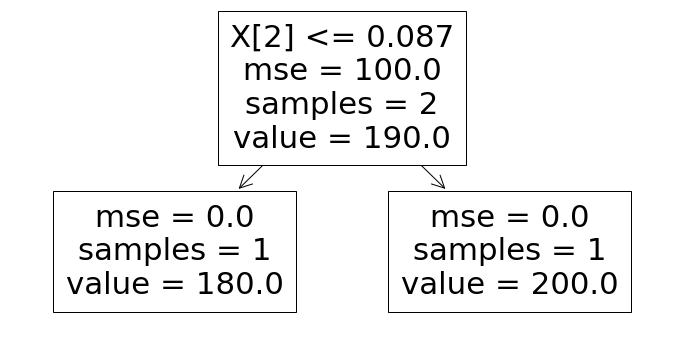

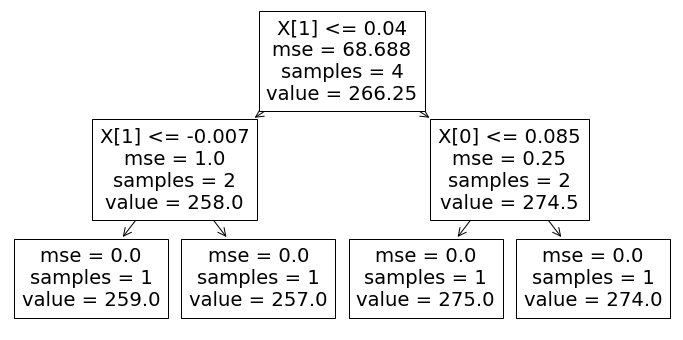

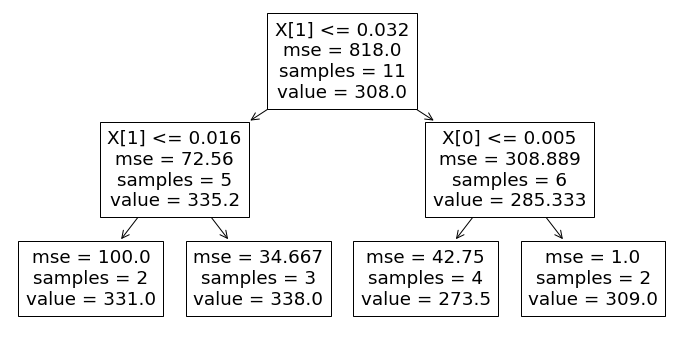

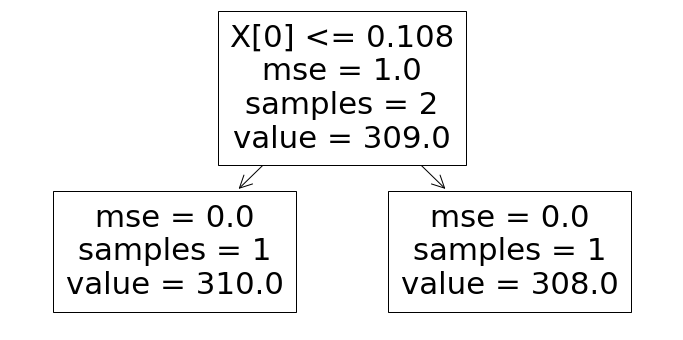

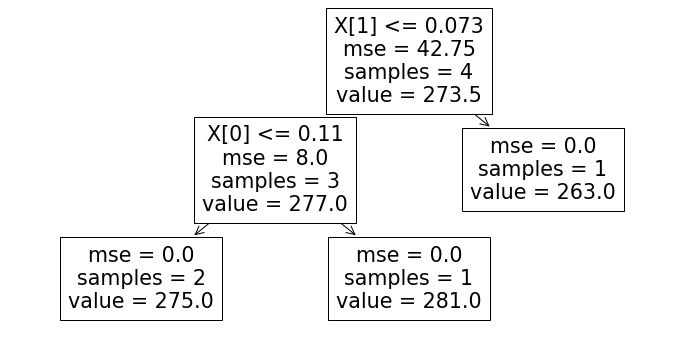

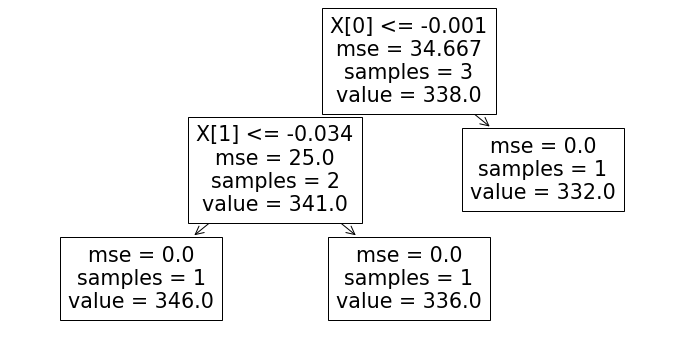

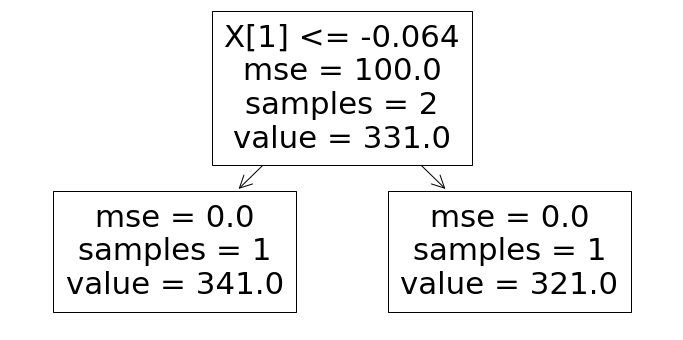

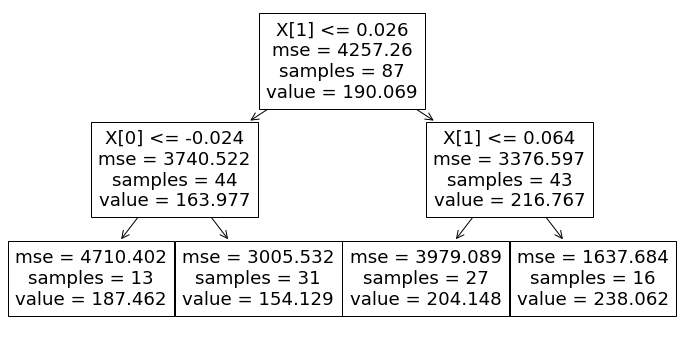

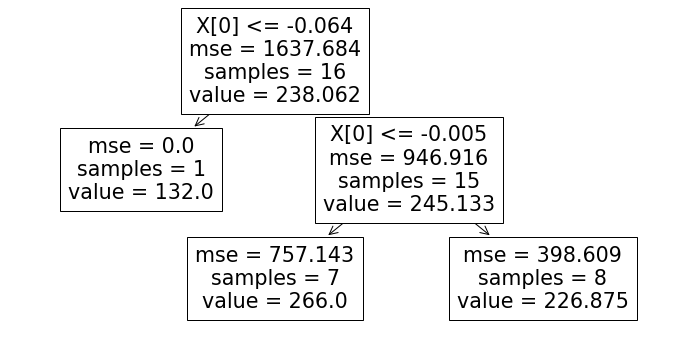

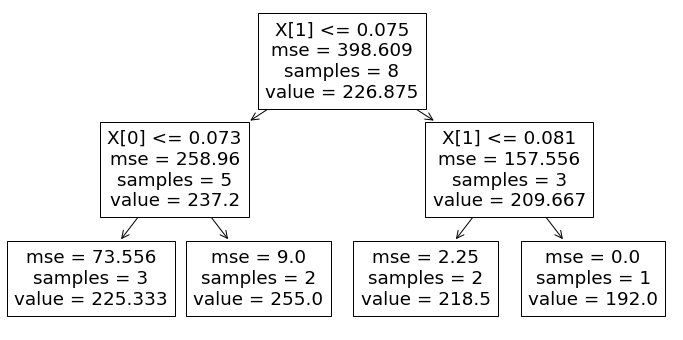

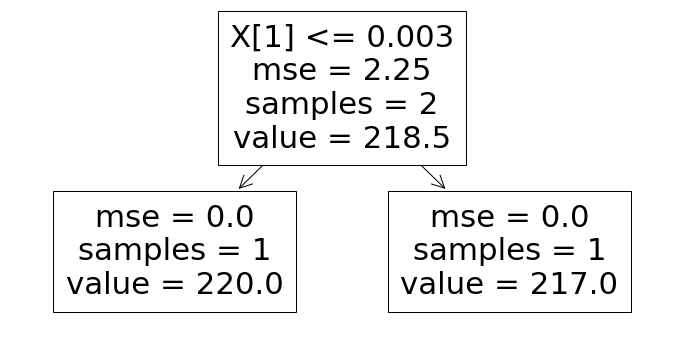

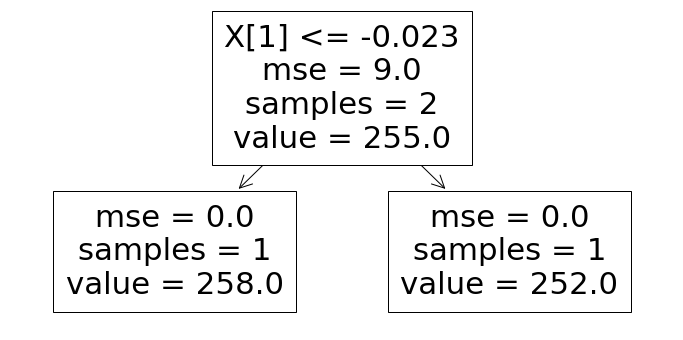

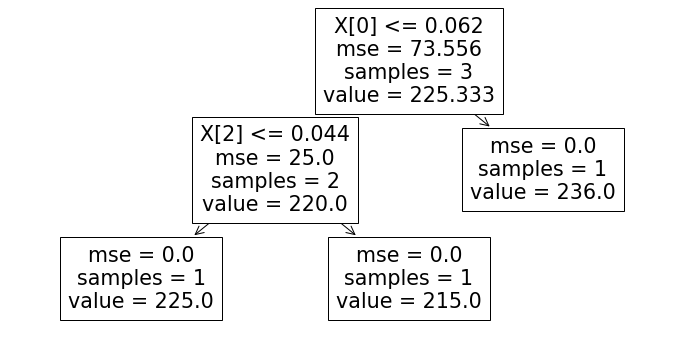

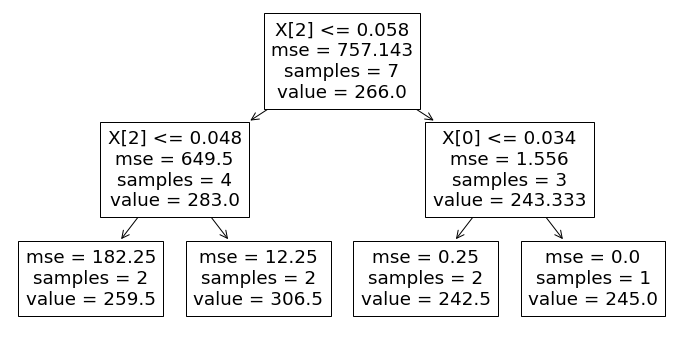

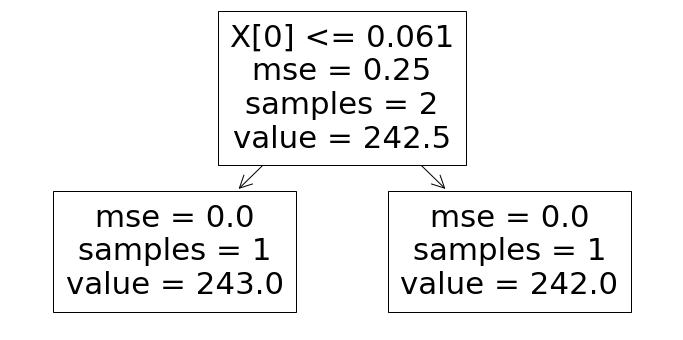

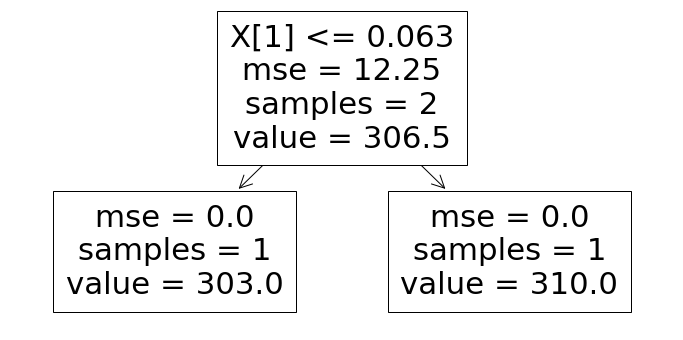

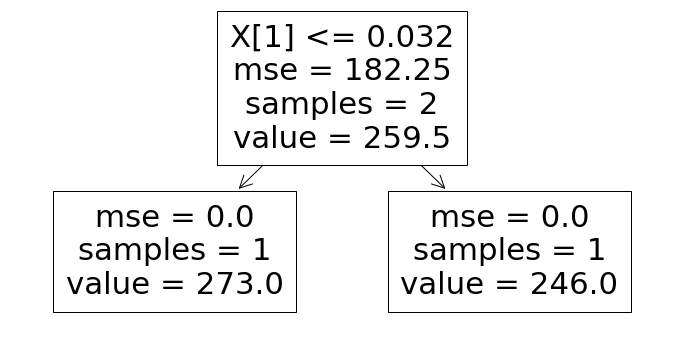

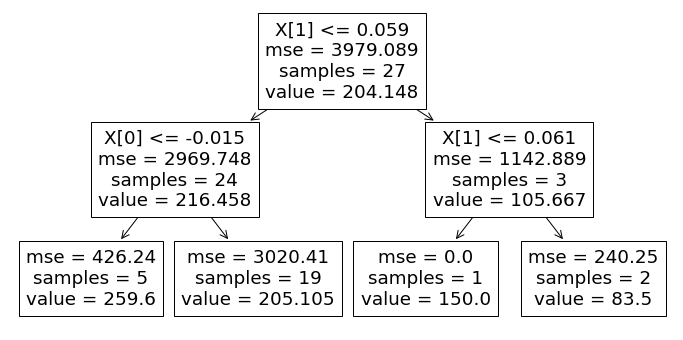

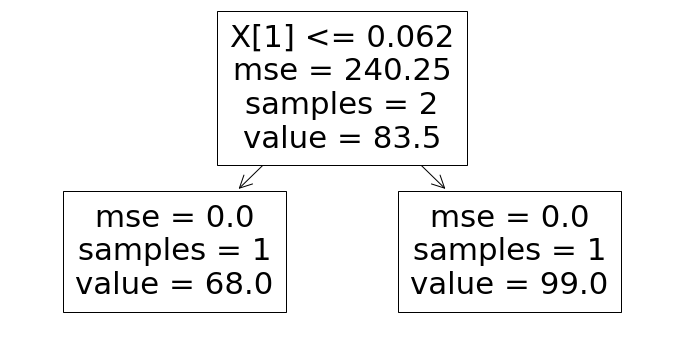

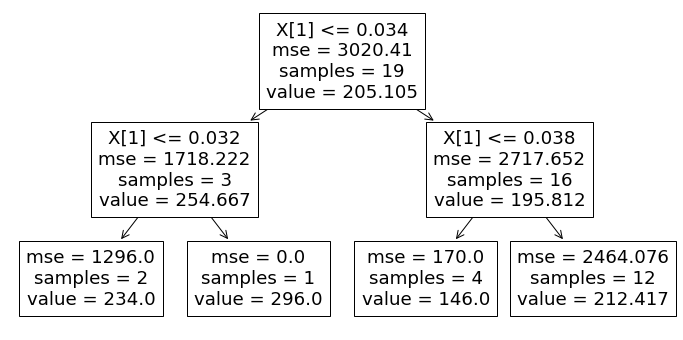

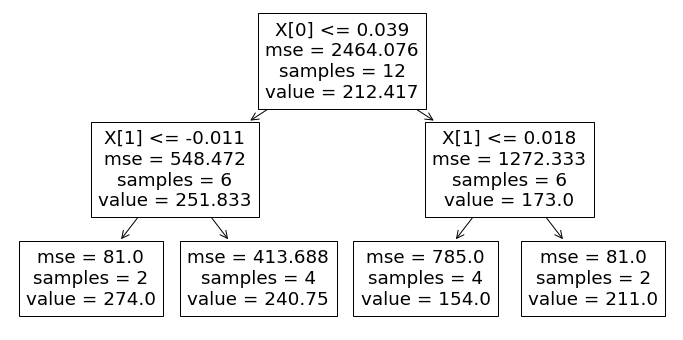

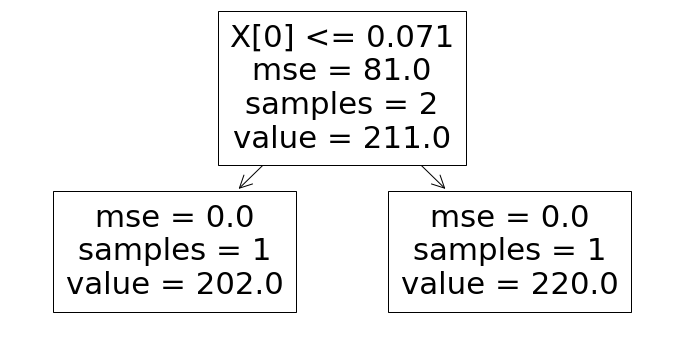

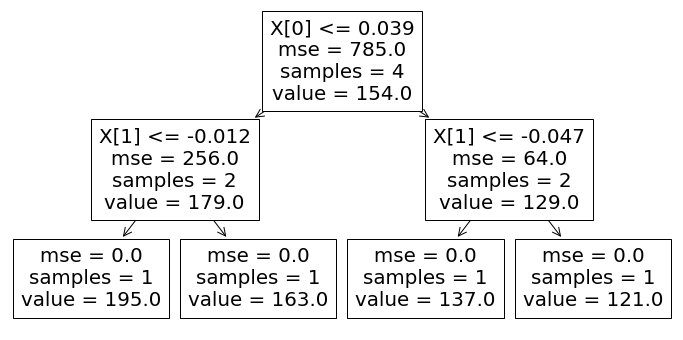

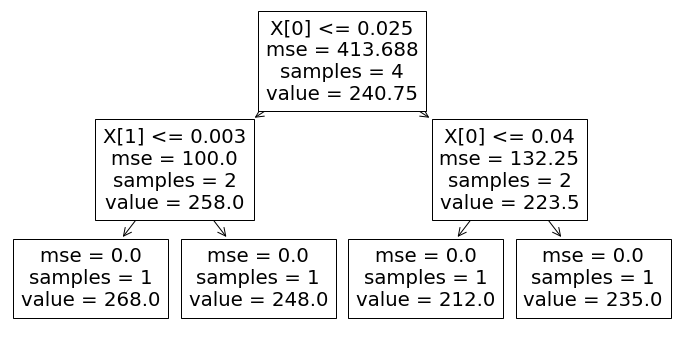

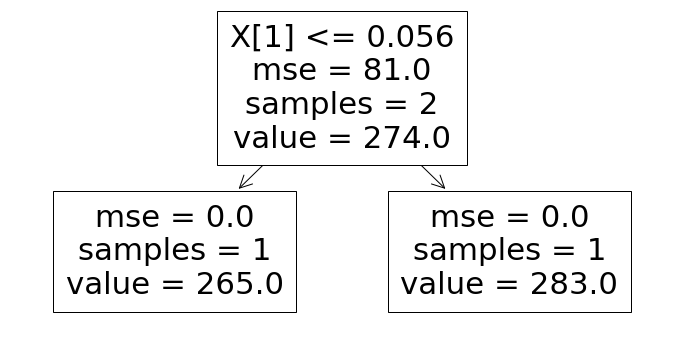

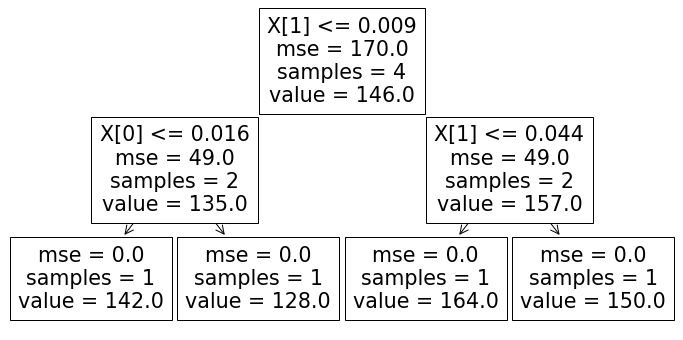

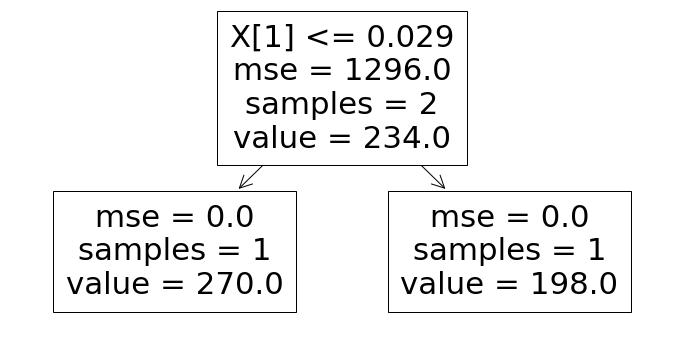

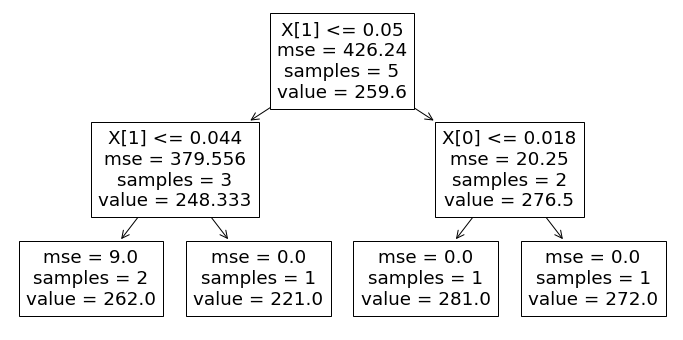

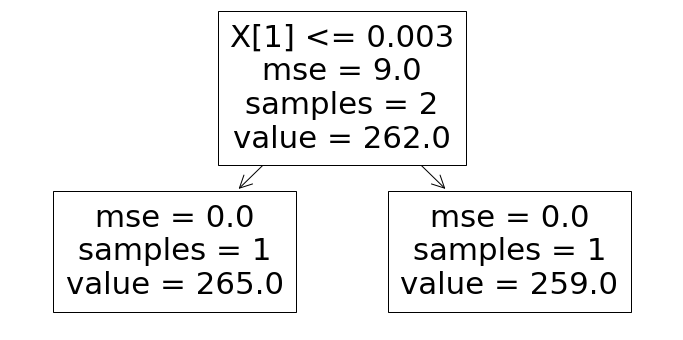

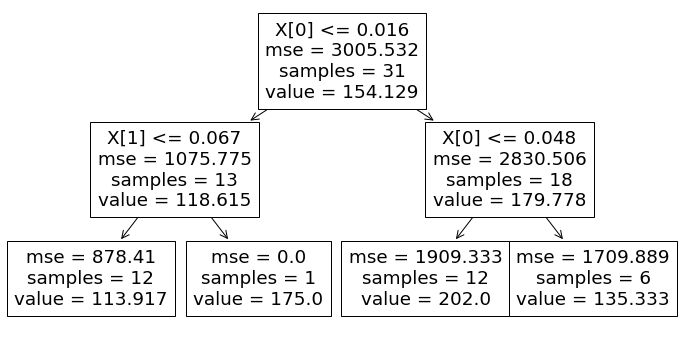

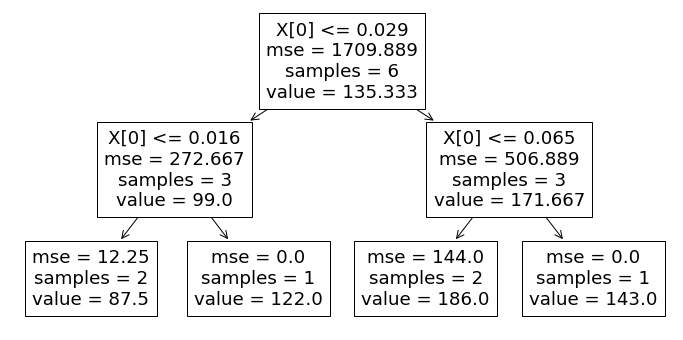

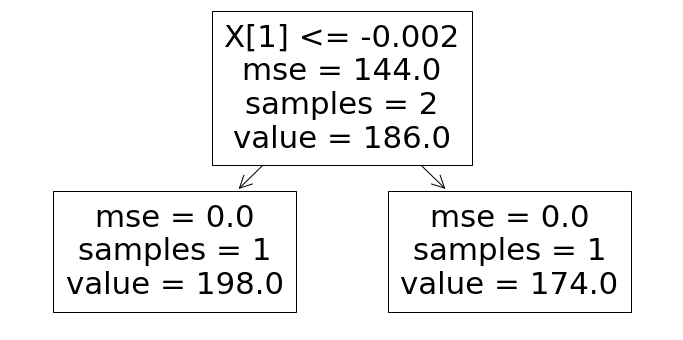

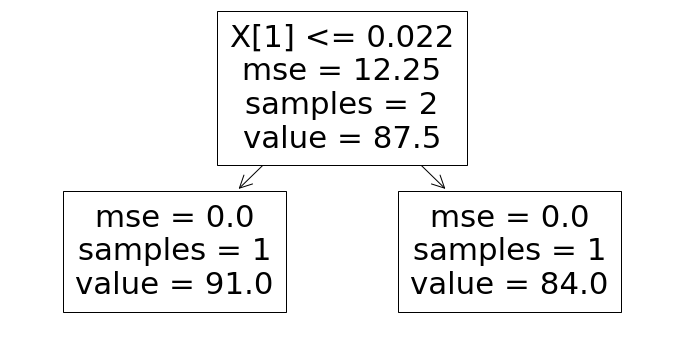

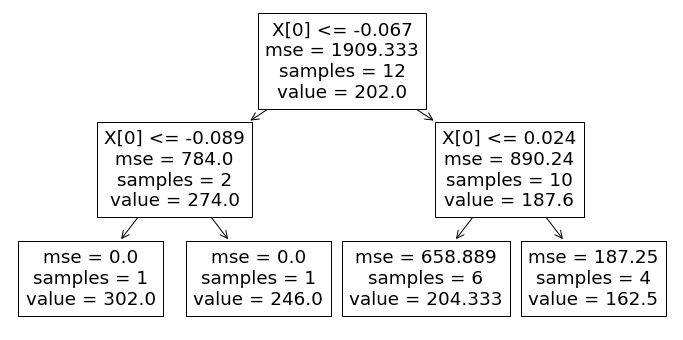

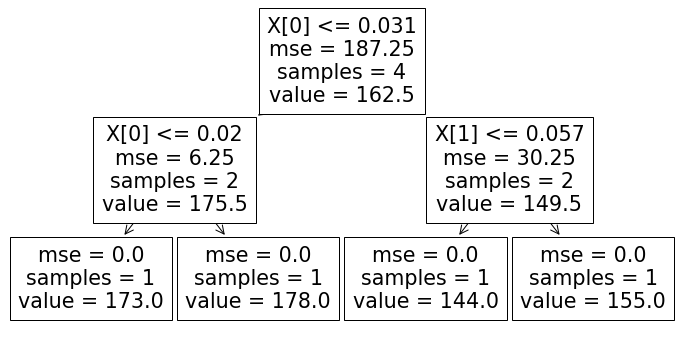

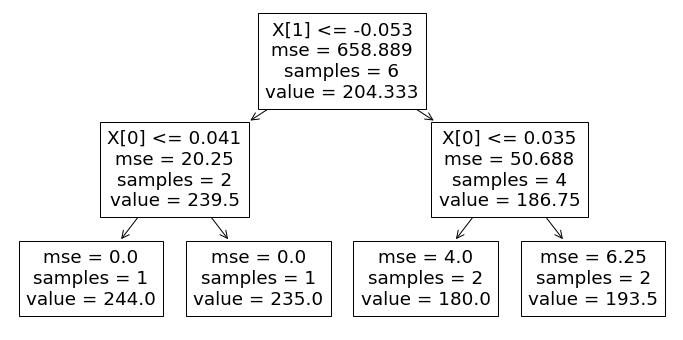

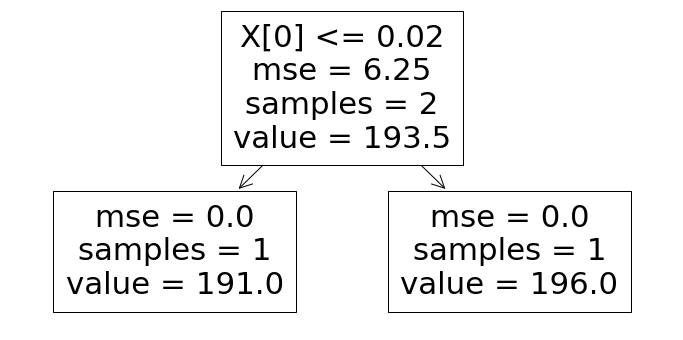

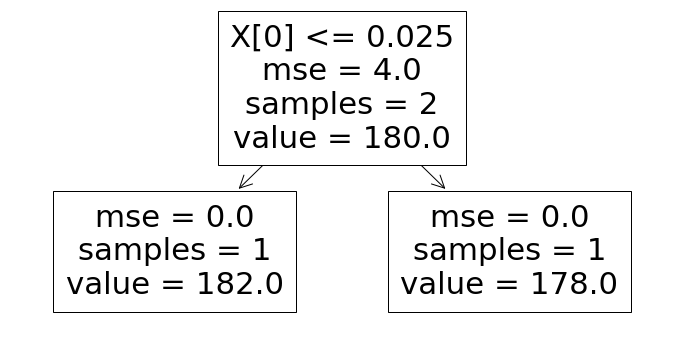

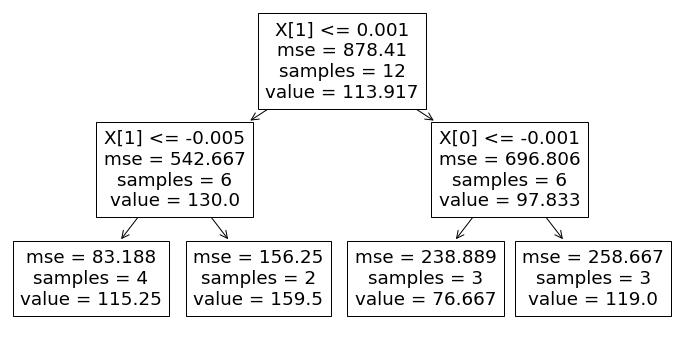

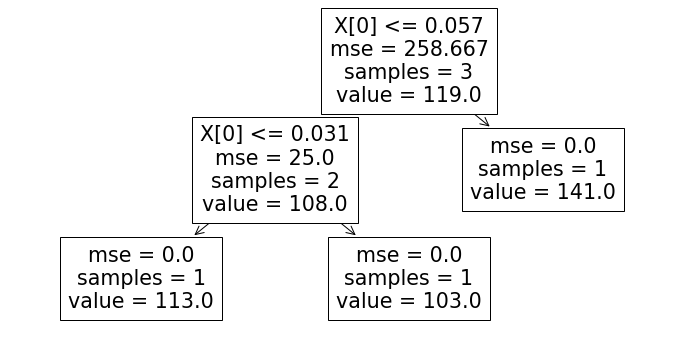

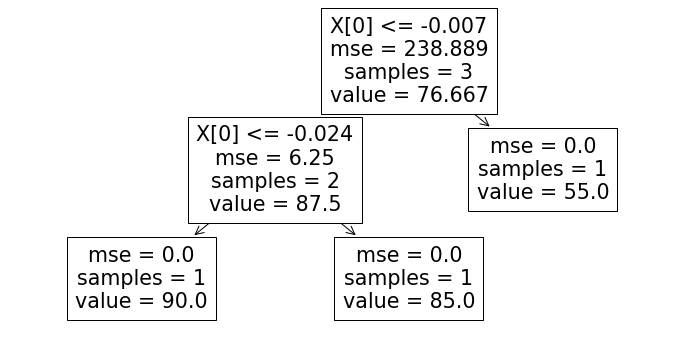

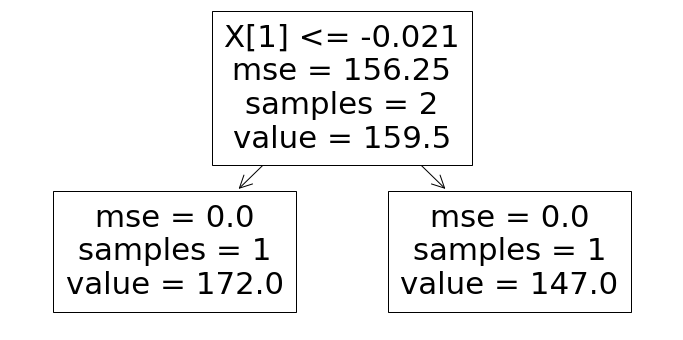

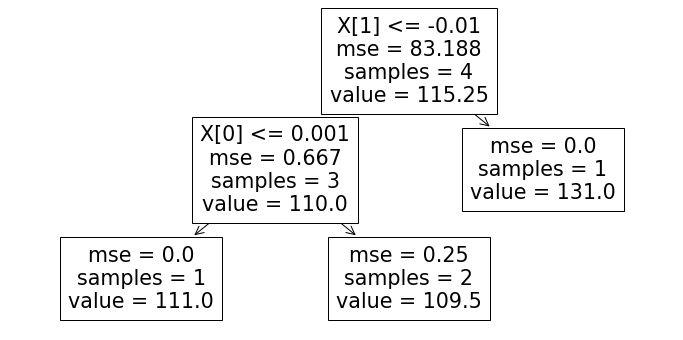

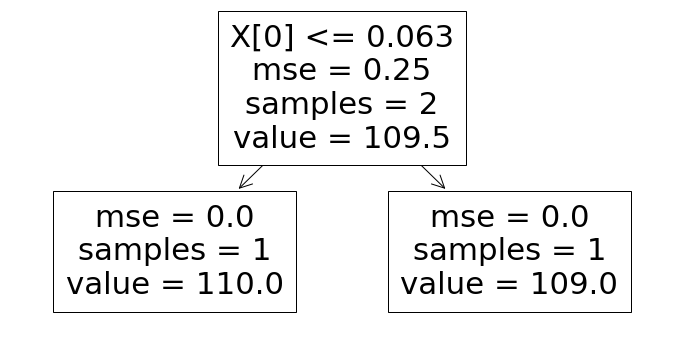

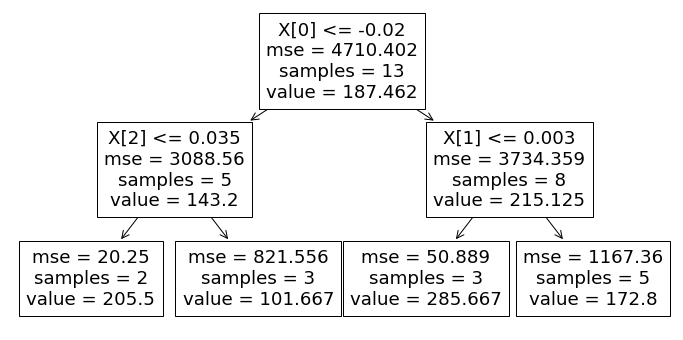

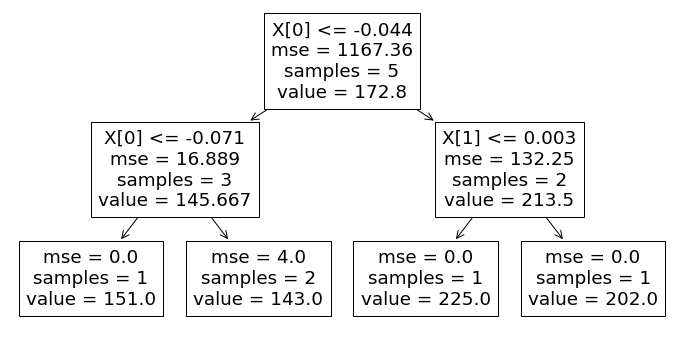

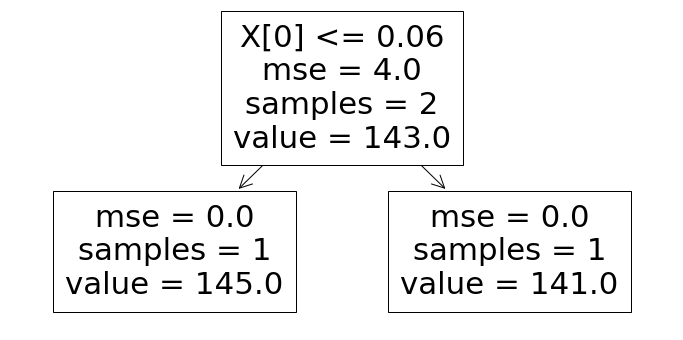

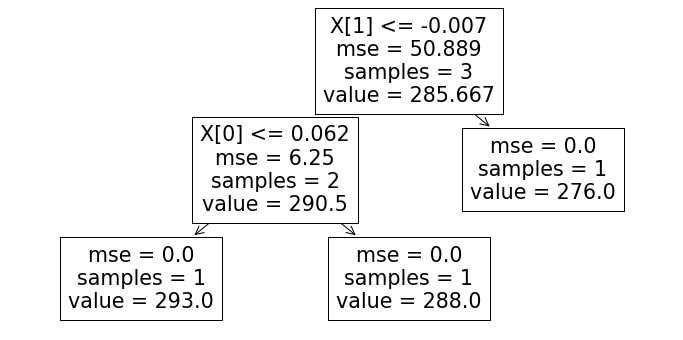

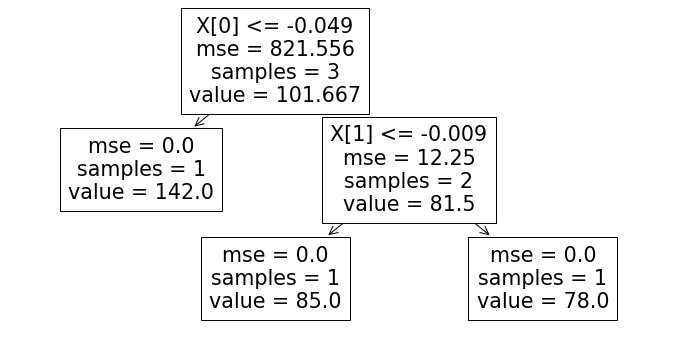

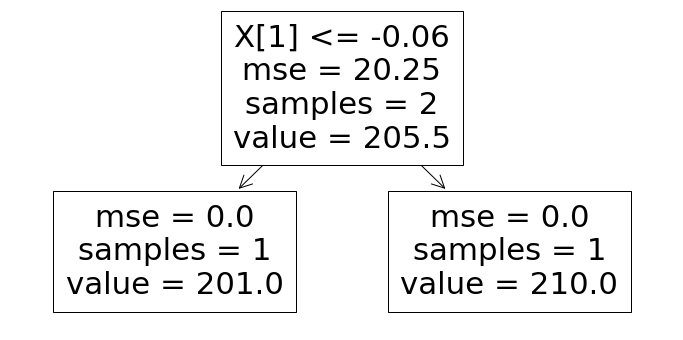

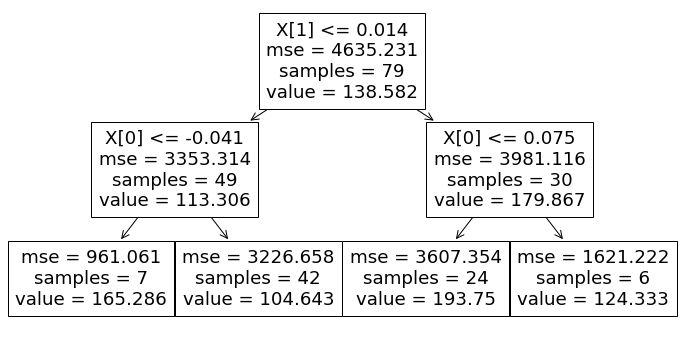

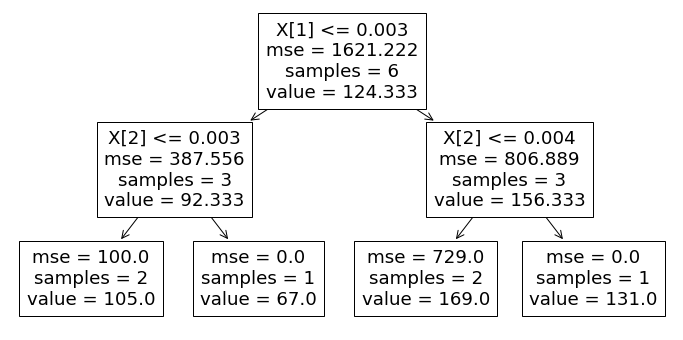

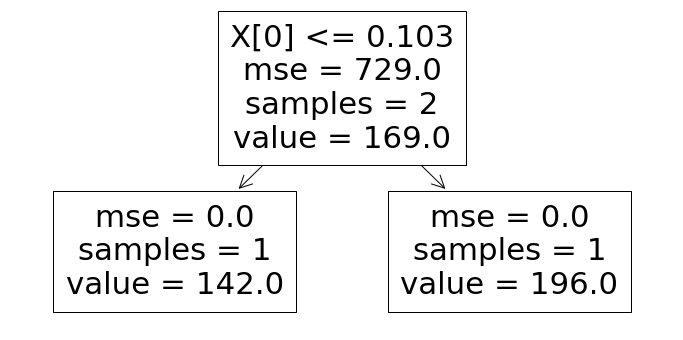

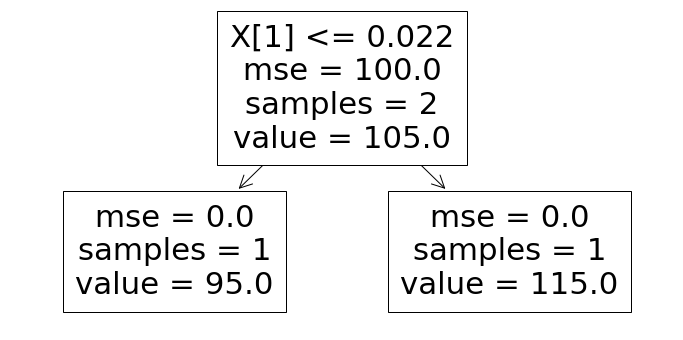

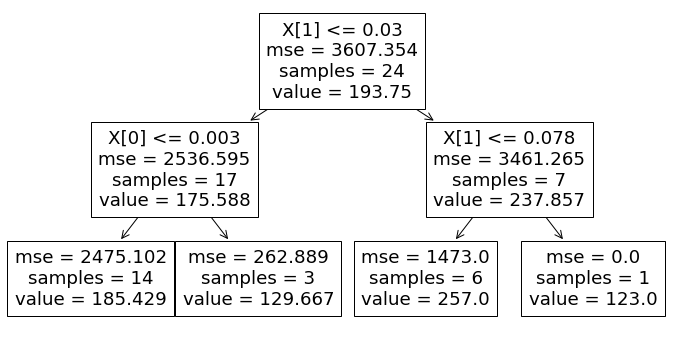

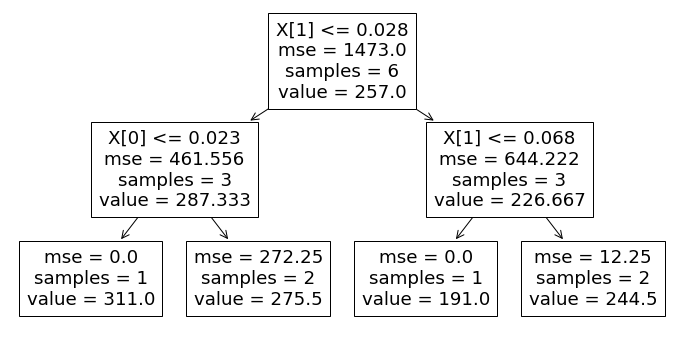

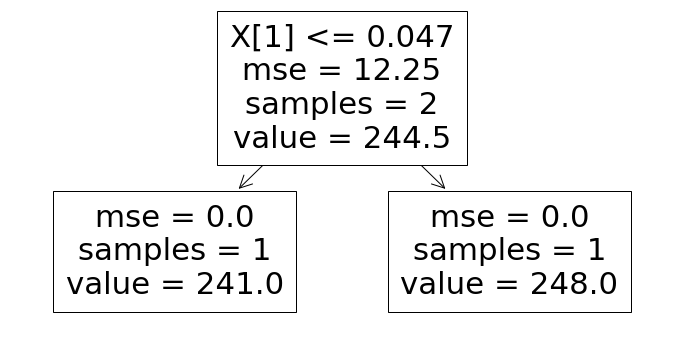

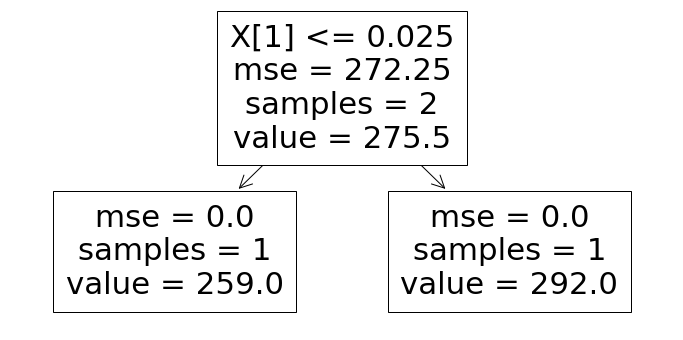

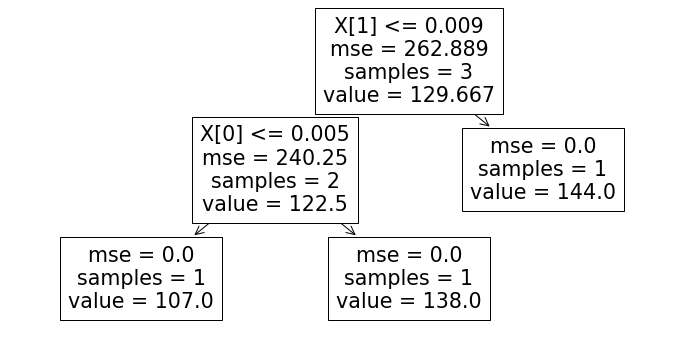

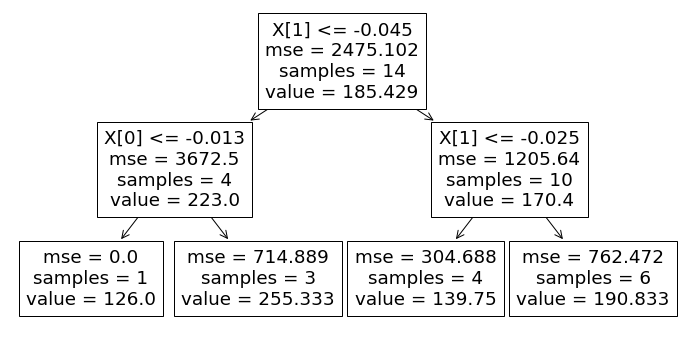

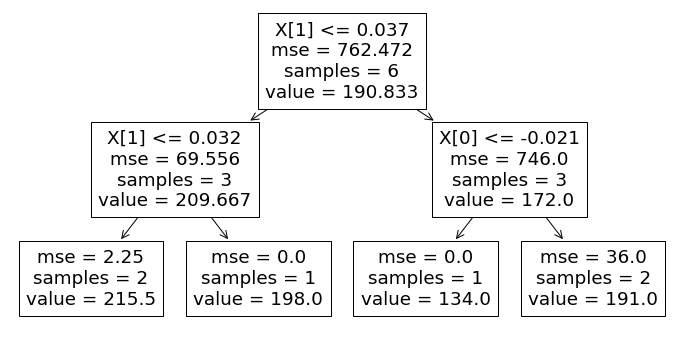

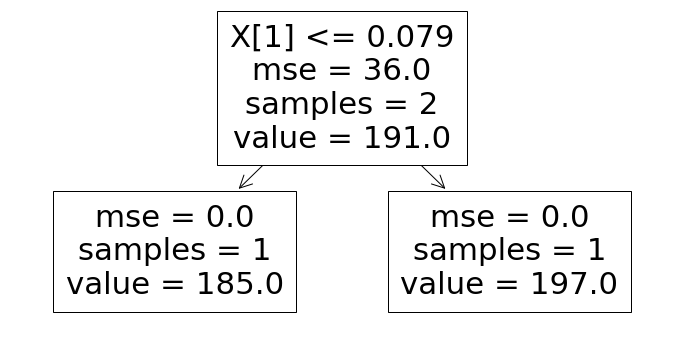

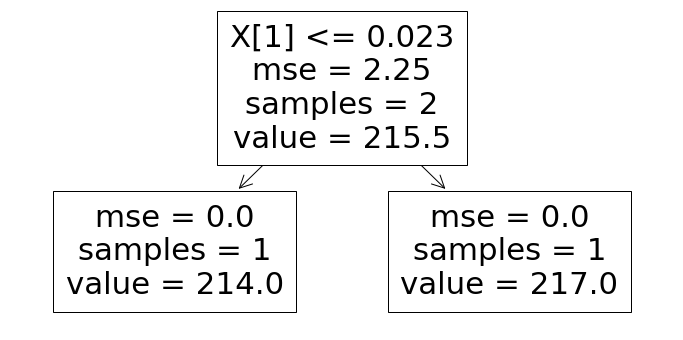

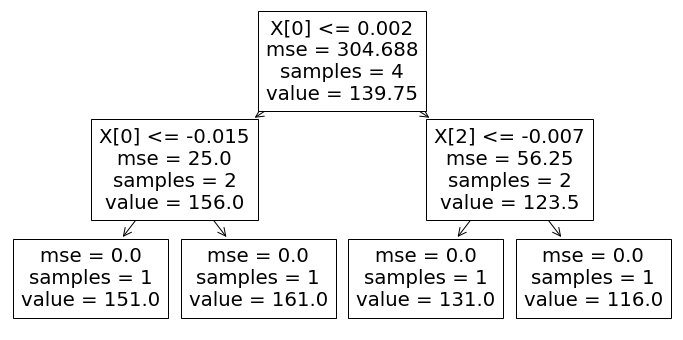

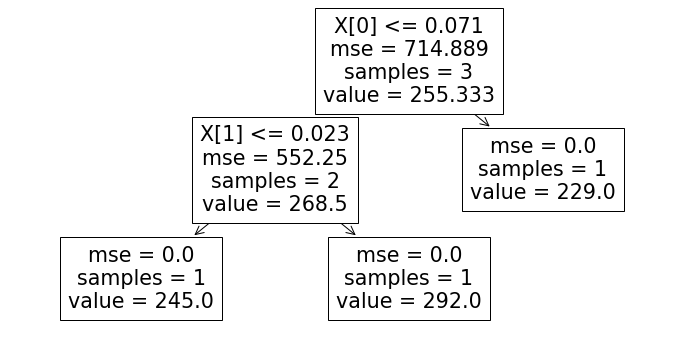

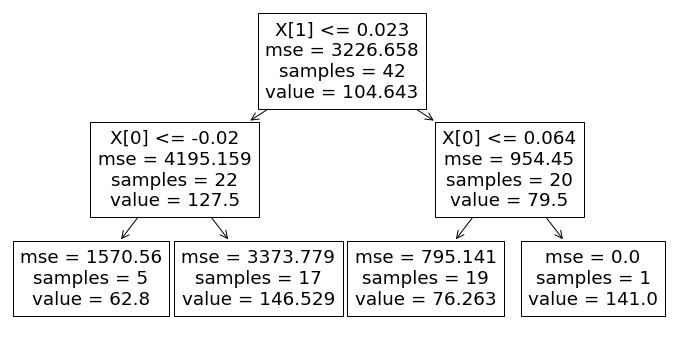

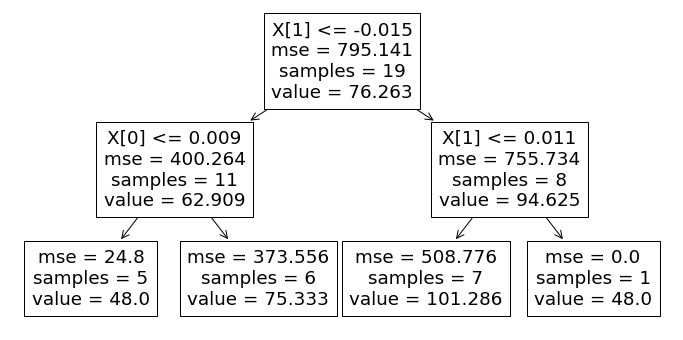

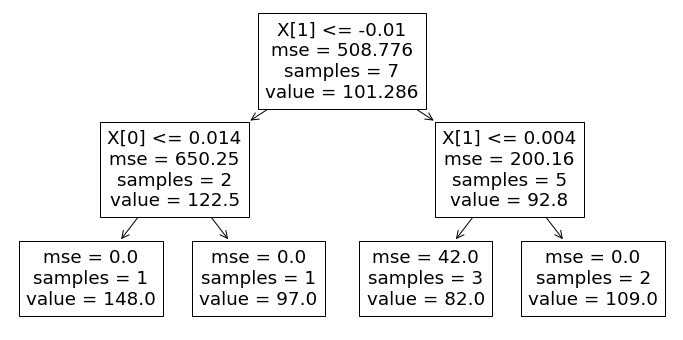

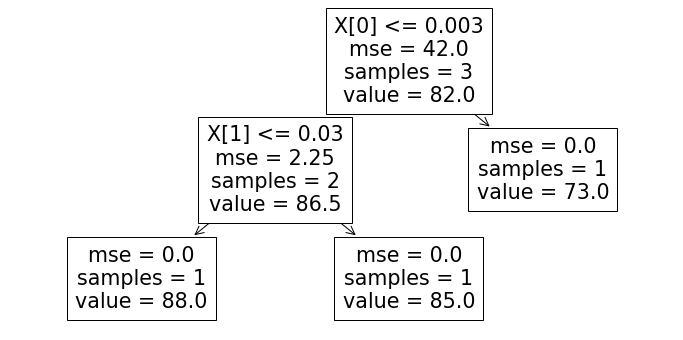

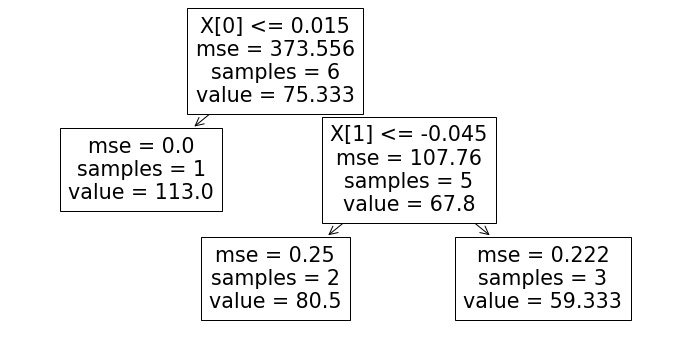

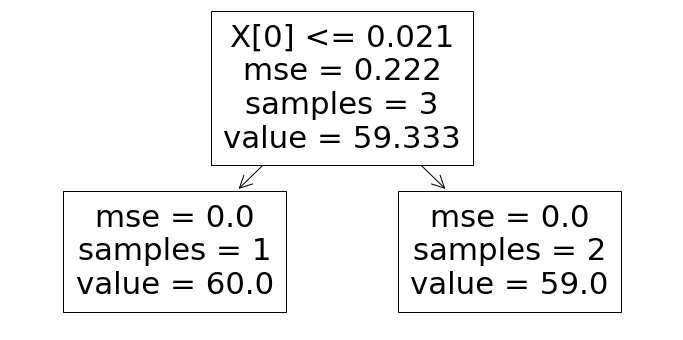

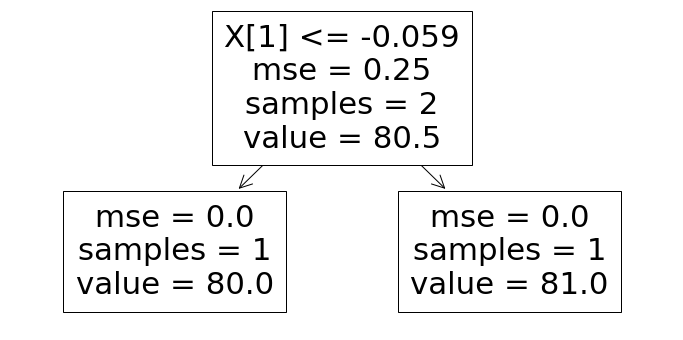

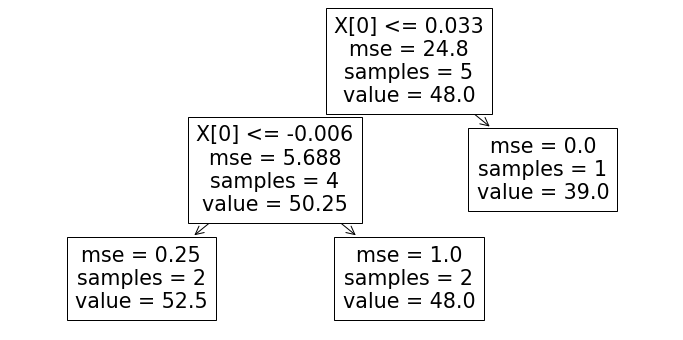

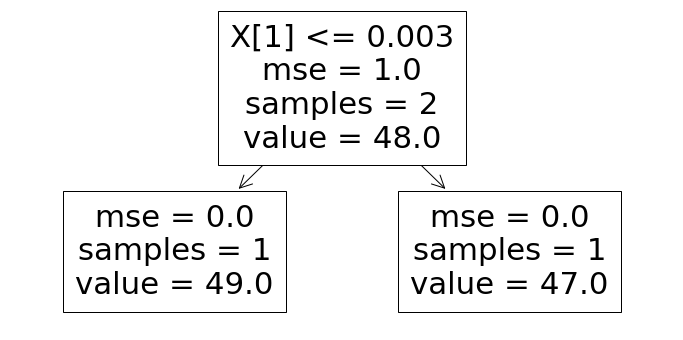

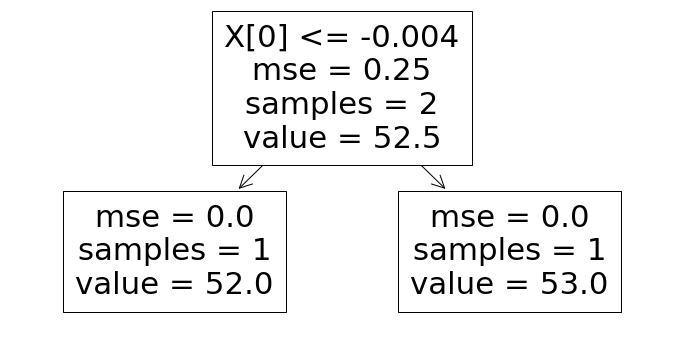

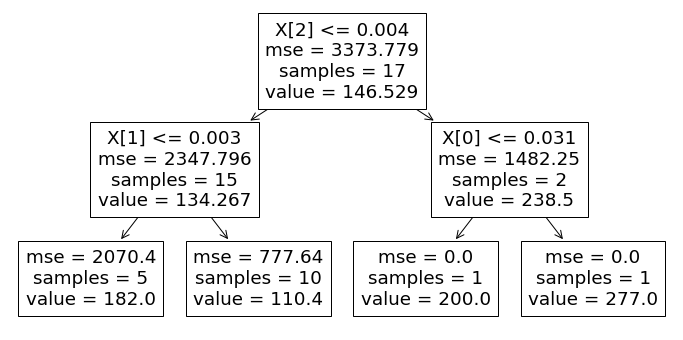

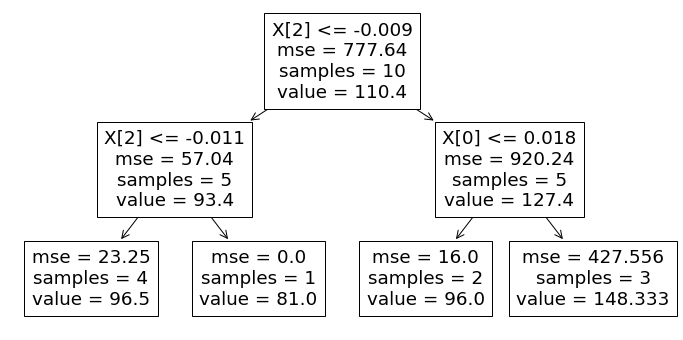

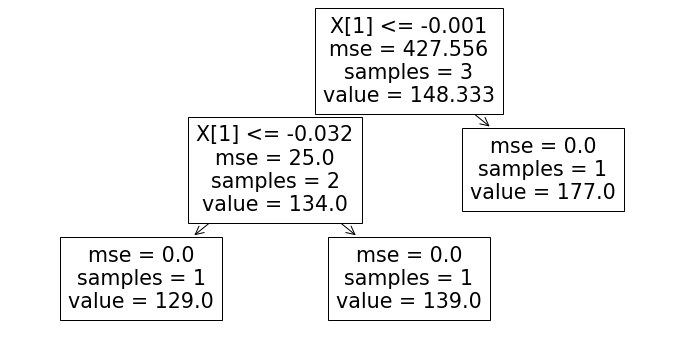

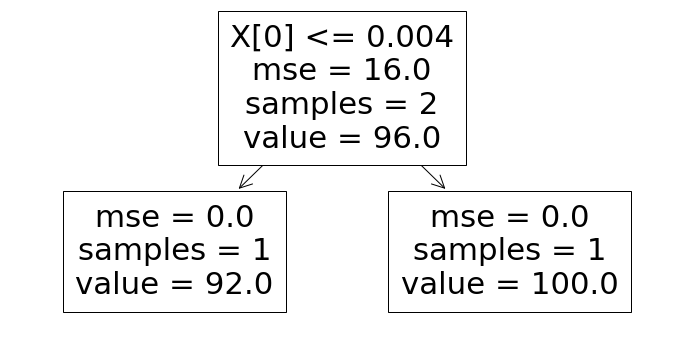

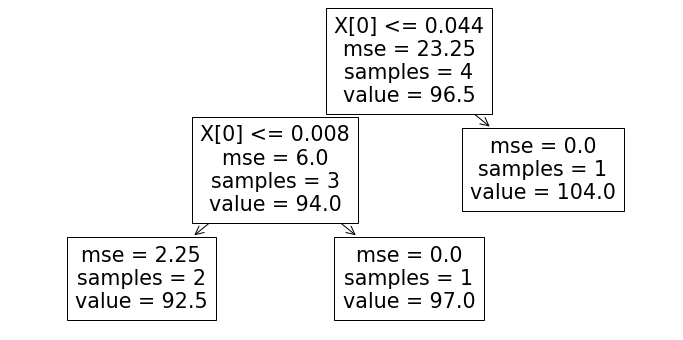

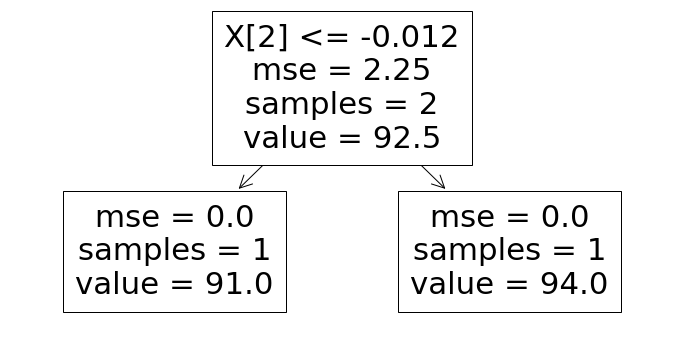

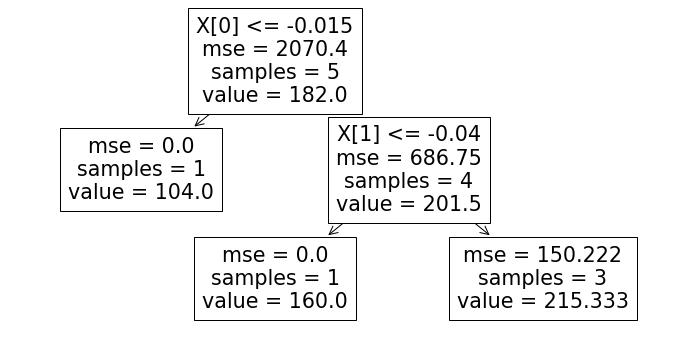

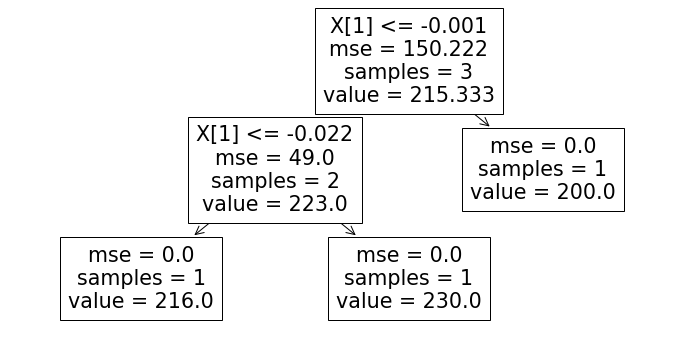

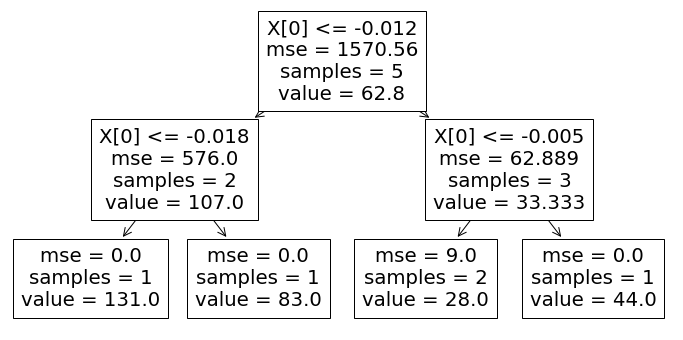

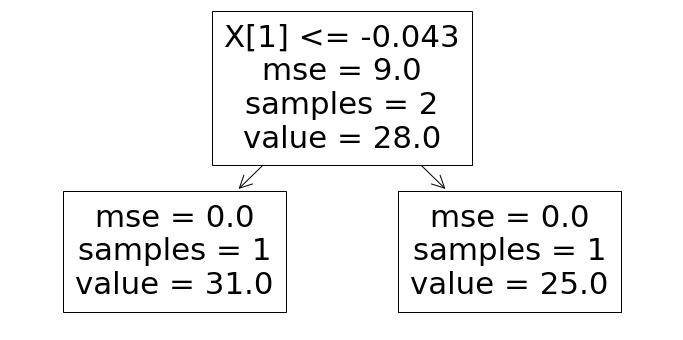

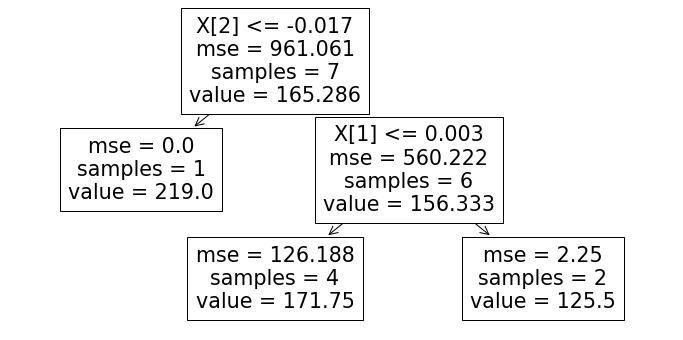

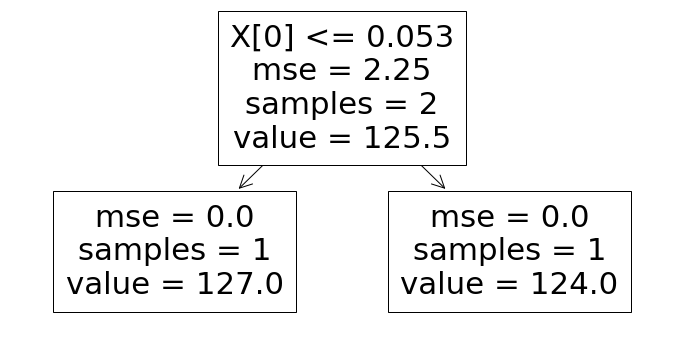

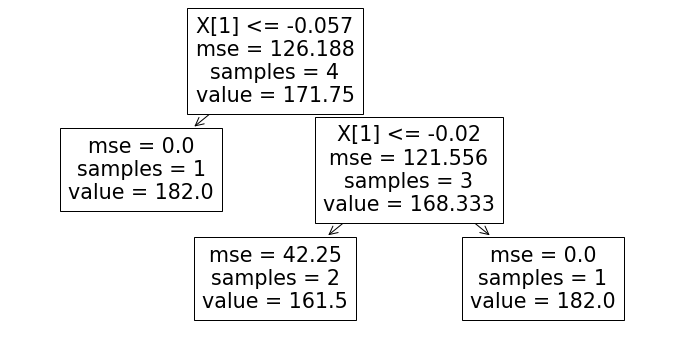

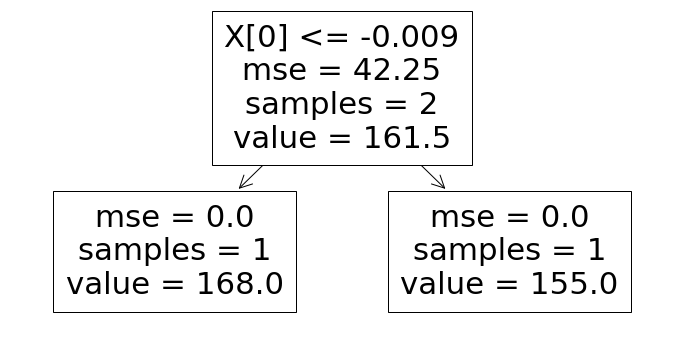

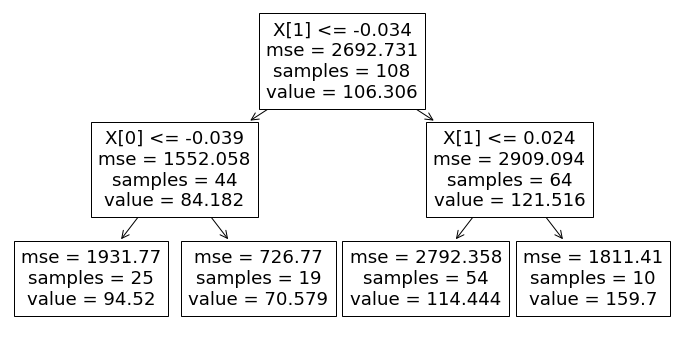

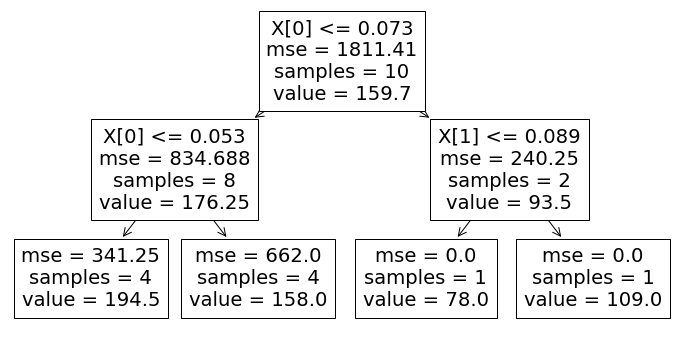

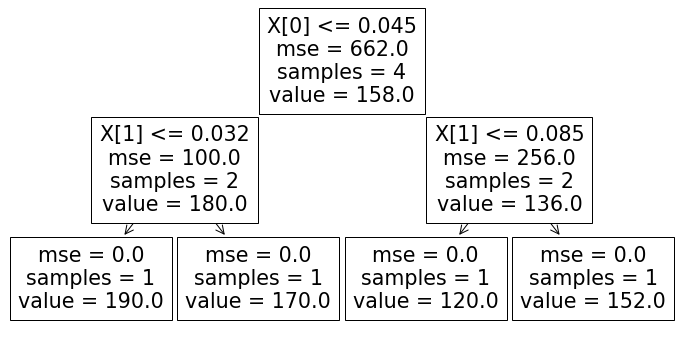

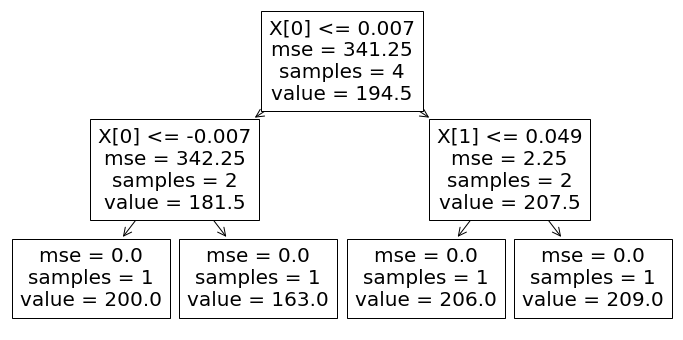

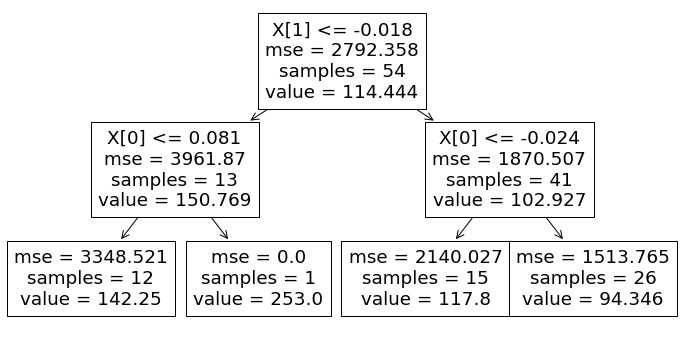

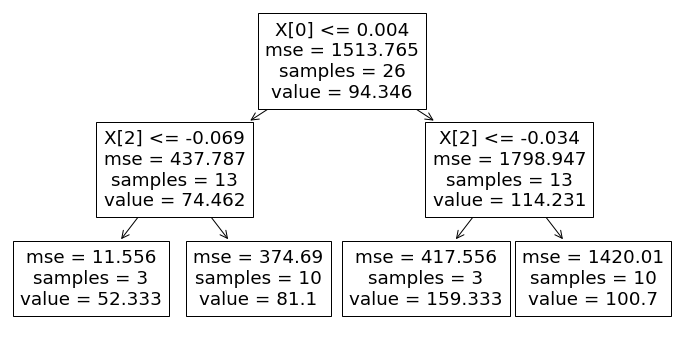

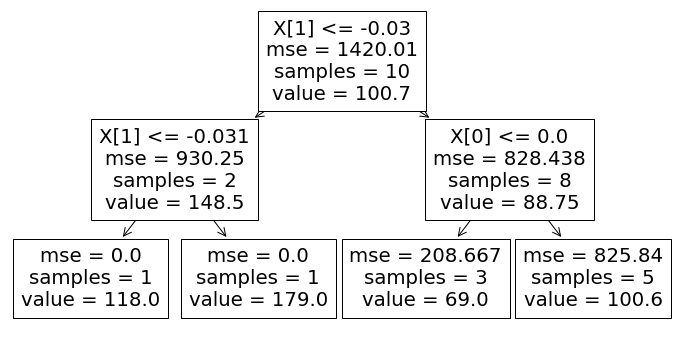

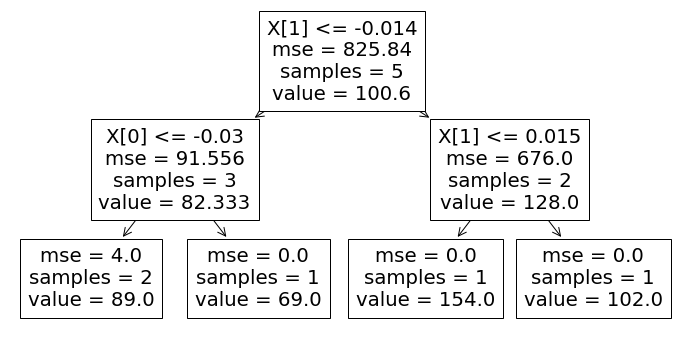

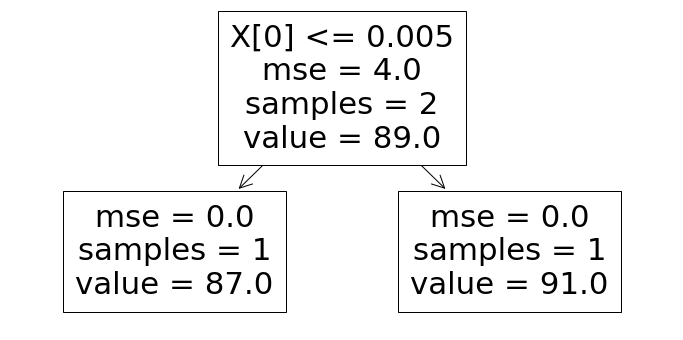

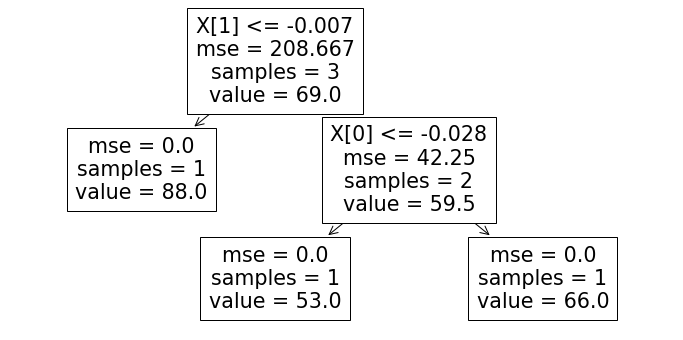

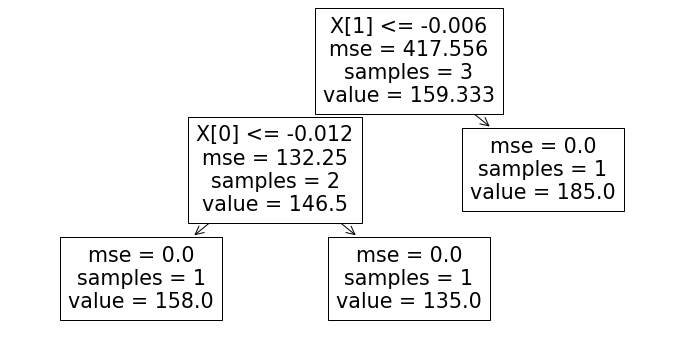

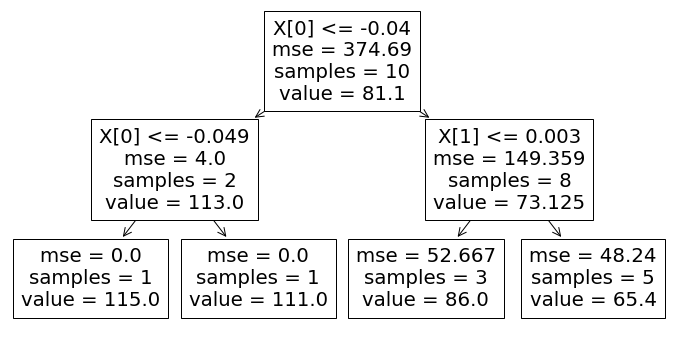

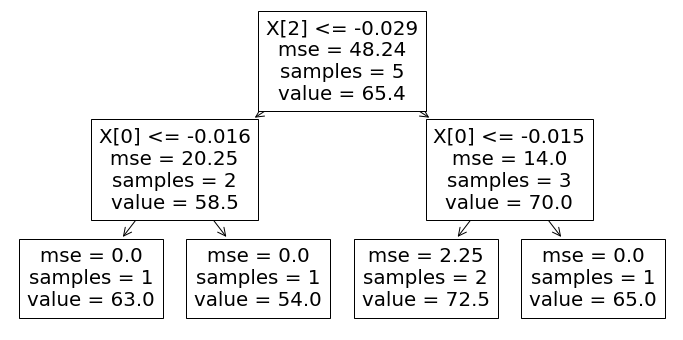

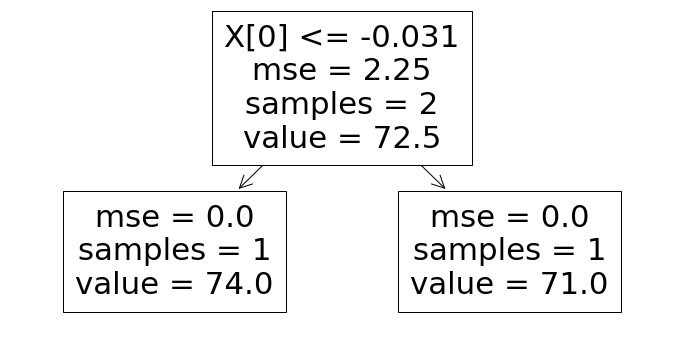

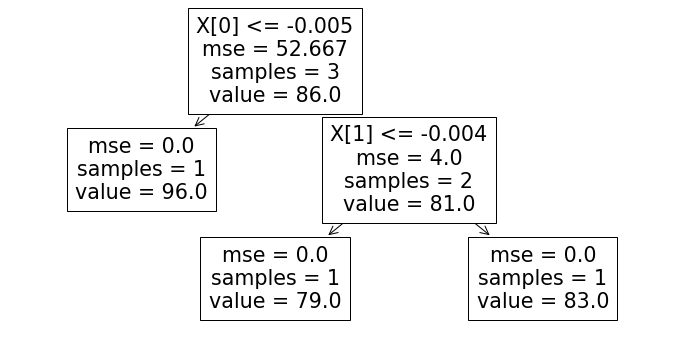

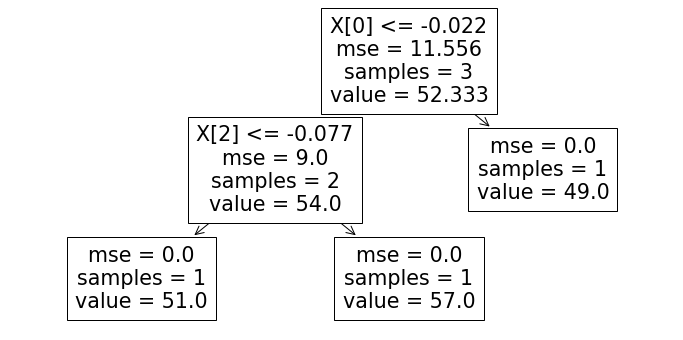

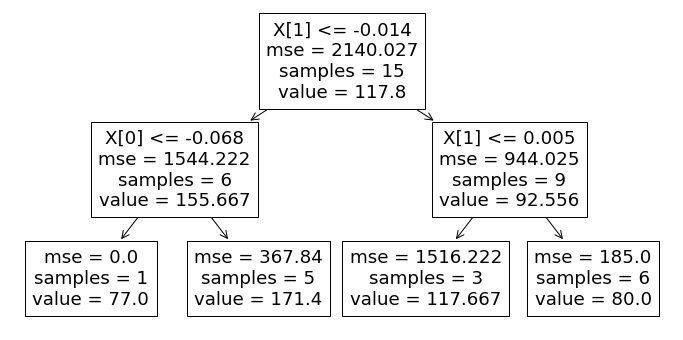

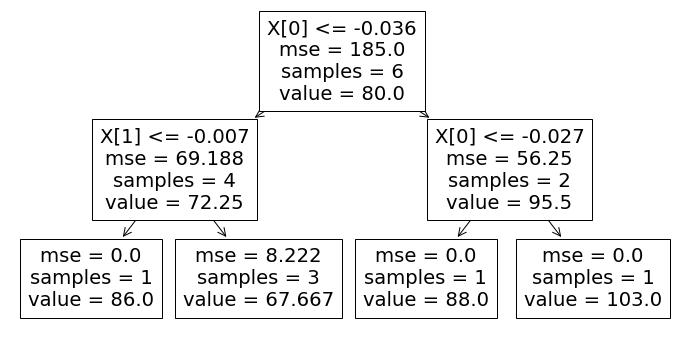

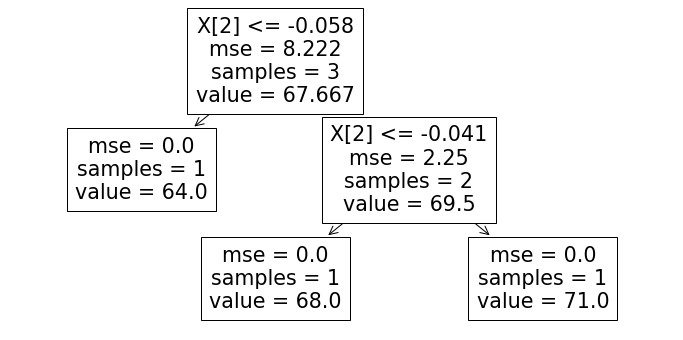

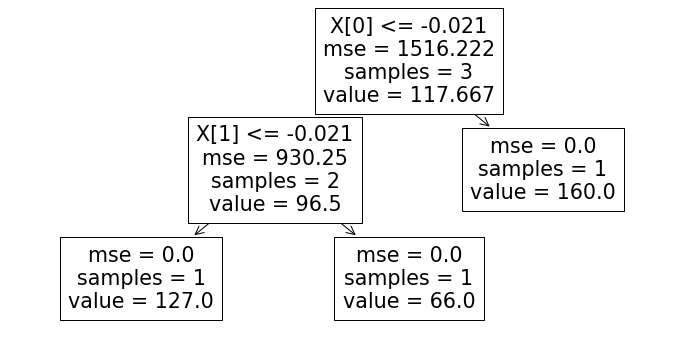

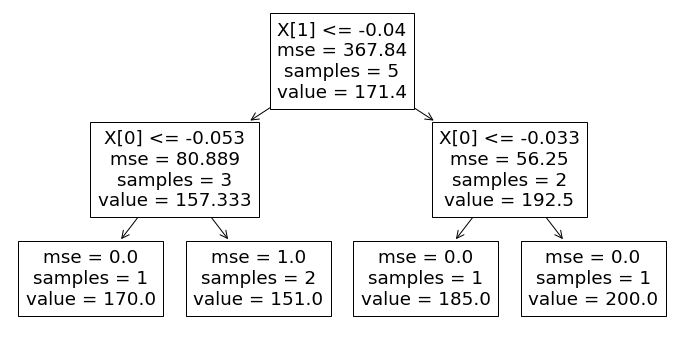

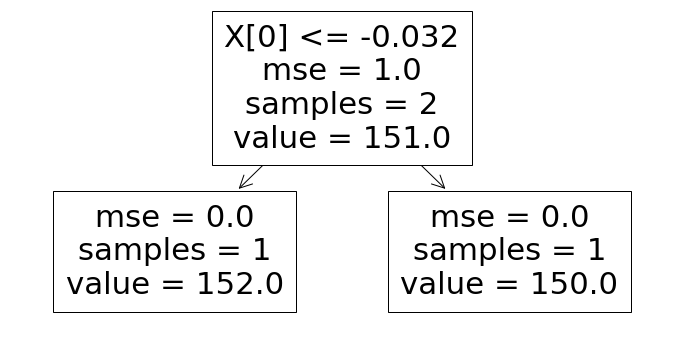

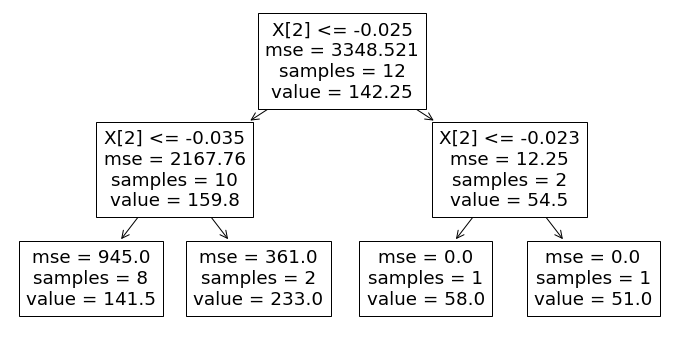

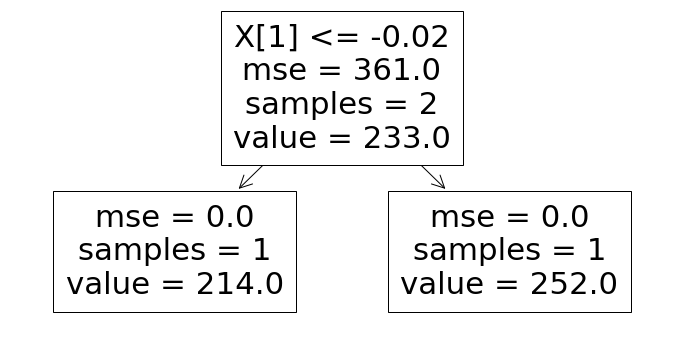

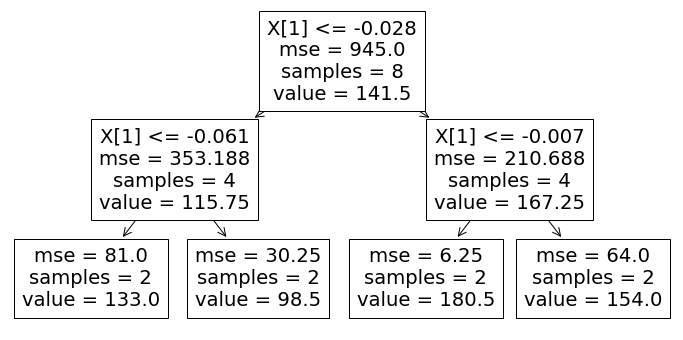

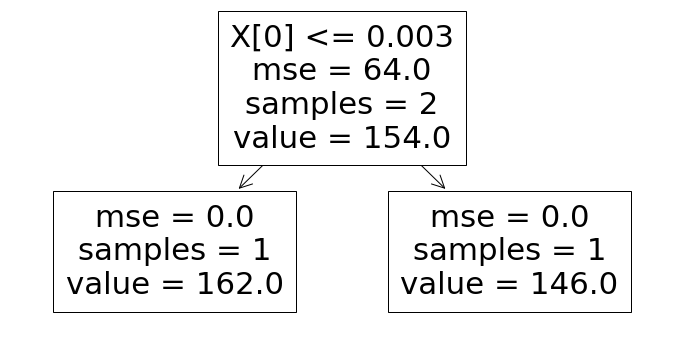

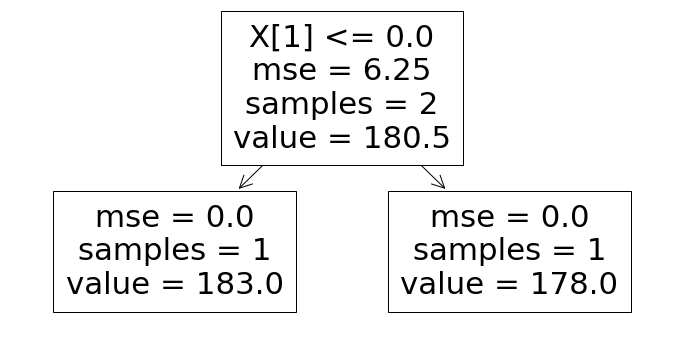

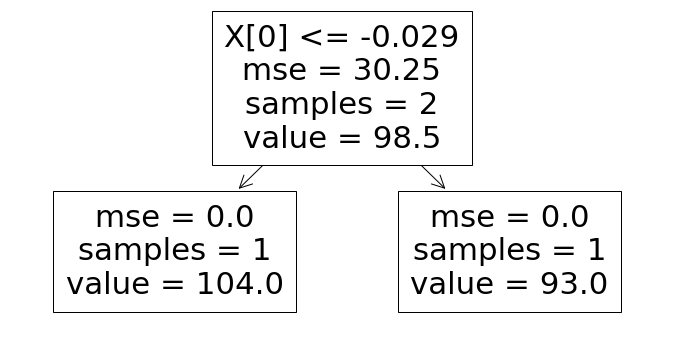

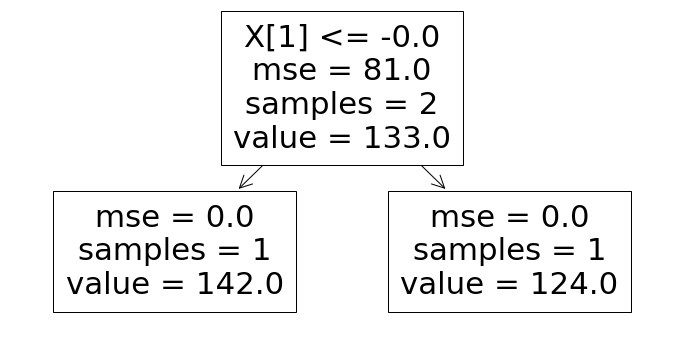

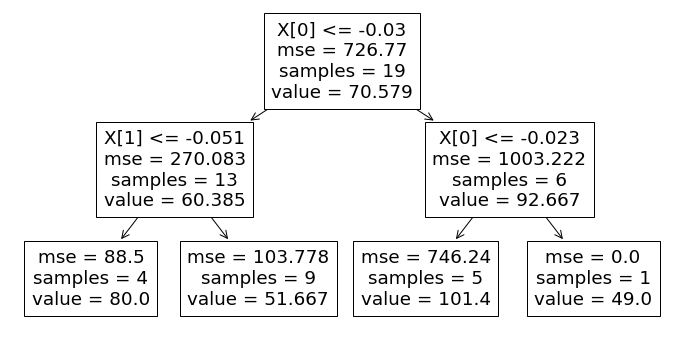

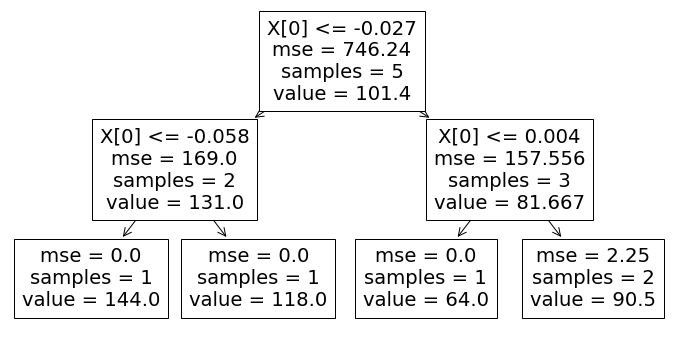

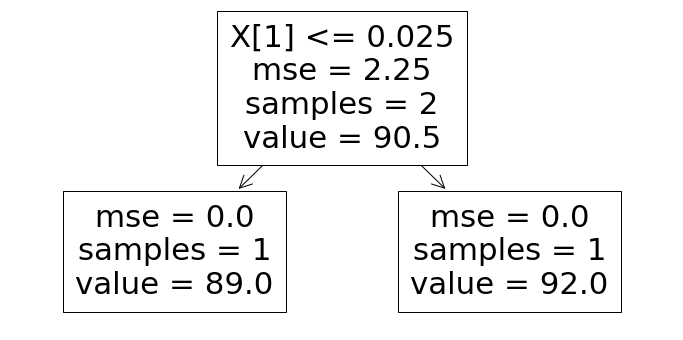

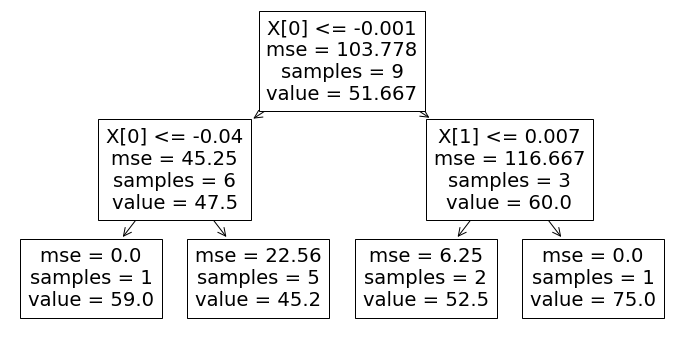

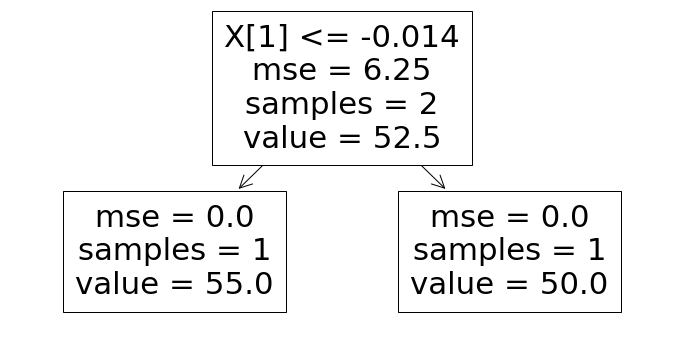

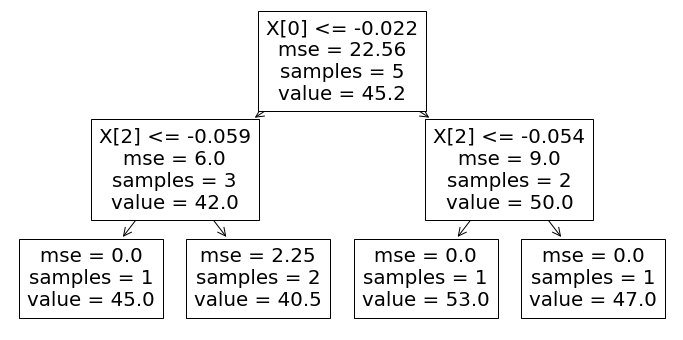

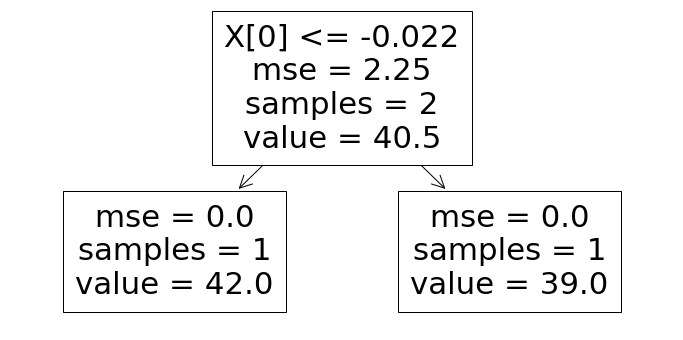

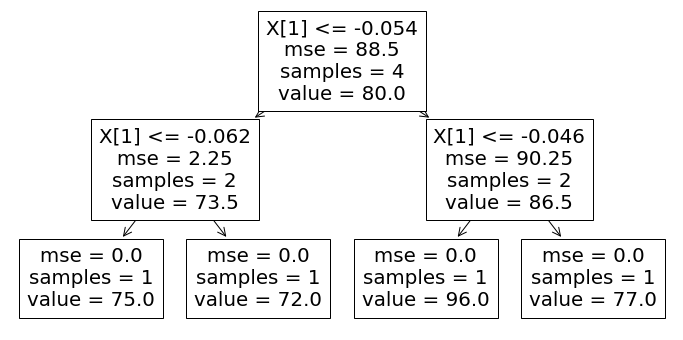

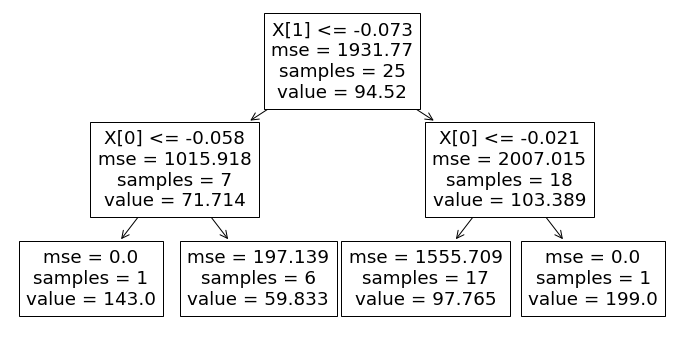

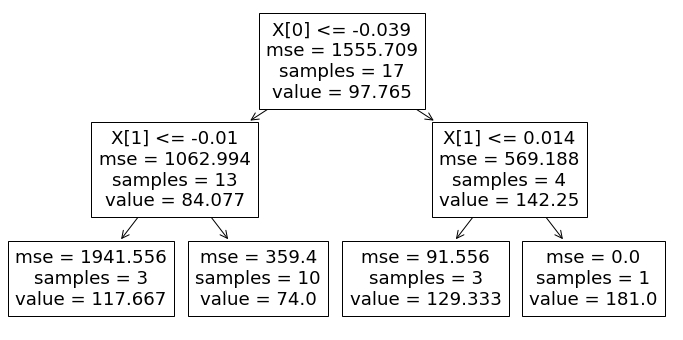

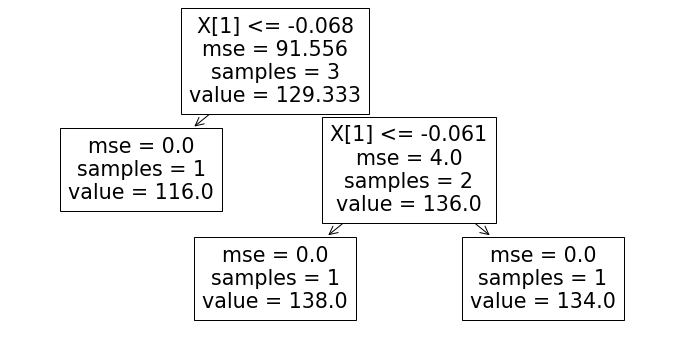

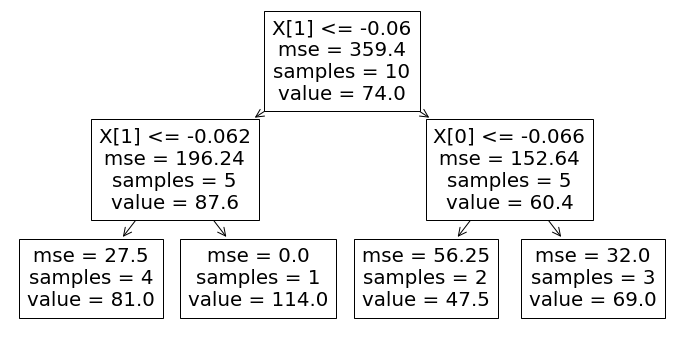

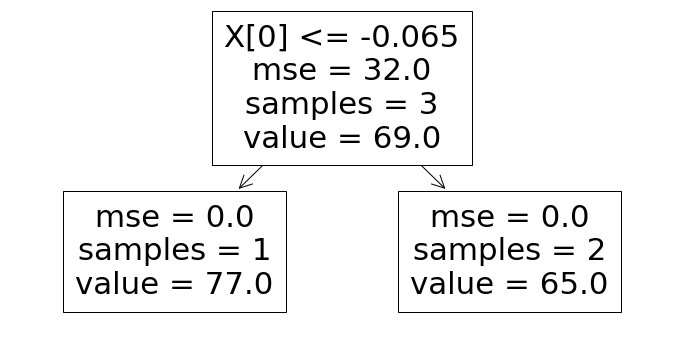

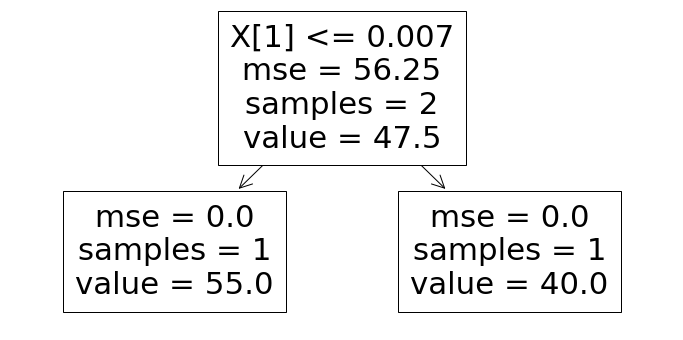

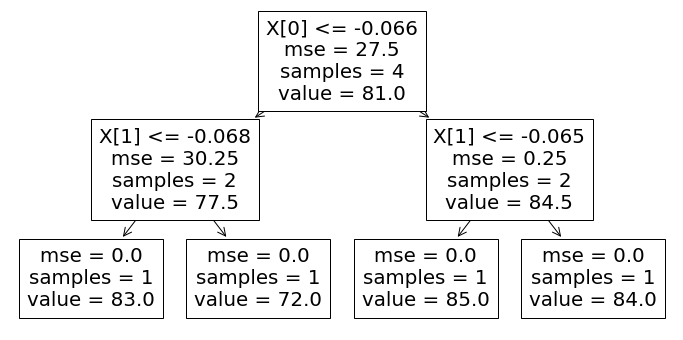

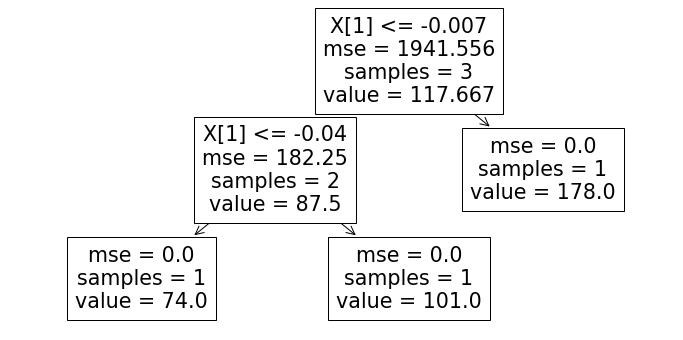

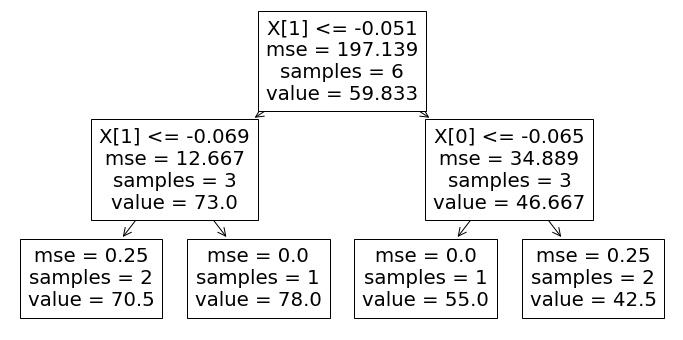

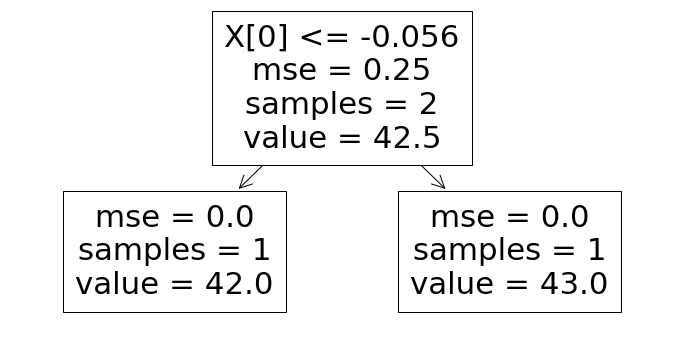

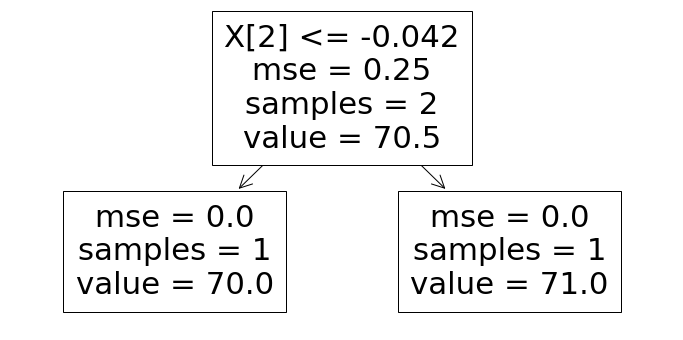

In [37]:
clf = DecisionTreeRegressor(max_depth=max_depth, random_state=random_state, max_features=len(groups[0]),
                             max_leaf_nodes=X.shape[0])

for i in range(cartgvtreeregressor.tree_.node_count):
    clf.tree_ = cartgvtreeregressor.tree_.nodes_splitting_trees[i]
    if(cartgvtreeregressor.tree_.nodes_splitting_trees[i] != None):
        fig, ax = plt.subplots(1, figsize=(12, 6))
        plot_tree(clf)
        plt.show()

# Example 3 : Breast cancer dataset and binary classification

## Data

In [69]:
#Loading of the data
data = load_breast_cancer()

X = data.data
y= data.target

#Split the data into train and test samples
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Represent the groups as an array containing the indexes of the group column/variable inside the data
# Here on the iris dataset we chose to regroup :
# Sepal Length and Sepal Width : Group 0
# Petal Length and Petal Width : Group 1
# Sepal Length and Petal Length : Group 2
# Sepal Width and Petal Width : Group 3
groups = np.array([[0,2,3,10,12,13,20,22,23],[1,4,5,11,14,15,21,24,25],[6,7,16,17,26,27],[8,9,18,19,28,29]], dtype=object)


In [70]:
print(data.DESCR)

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        worst/largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 0 is Mean Radi

## Parameters

In [71]:
sample_size = X_train.shape[0]

len_groups = np.array([len(group) for group in groups])

# ys = np.atleast_1d(y_train)
min_samples_leaf = 1 # The minimum number of samples in a leaf
min_samples_split = 2 # The minimum number of samples needed to split the node
min_weight_leaf = 0 # The minimum weight in a leaf
random_state = 2547 # The seed
max_depth = None # The maximal depth for the splitting_tree
max_depth_splitting_tree = 2
mgroup = len(groups) # The number of group to visit
mvar = len_groups # The number of variable to visit
min_impurity_decrease = 0.0 # The minimum decrease in impurity that we want to achieve after a split
min_impurity_split = 0.0 # The minimum impurity under which the node is considered a leaf
min_impurity_decrease_splitting_tree = 0.0
min_impurity_split_splitting_tree = 0.0

## Object construction

In [72]:
cartgvtreeclassifier = DecisionCARTGVTreeClassifier(mvar=mvar, 
                            mgroup=mgroup,
                            random_state=random_state, 
                            max_depth_splitting_tree=max_depth_splitting_tree)

## Tree construction

In [75]:
cartgvtreeclassifier.fit(X_train, y_train, groups)

DecisionCARTGVTreeClassifier(mgroup=4, mvar=array([9, 9, 6, 6]),
                             random_state=2547)

## Classification score

In [76]:
cartgvtreeclassifier.score(X_test, y_test)

0.9095744680851063

# Example 4 : Breast cancer dataset and random forest classifier

## Object construction

In [78]:
rfgv = RFGVClassifier(n_jobs=4, 
                      n_estimators=100, 
                      mvar="root", 
                      mgroup=len(groups)/3, 
                      max_depth_splitting_tree=2, 
                      random_state=2547, 
                      verbose=0) #verbose >1 for text

## Forest construction

In [79]:
rfgv.fit(X_train, y_train, groups)

RFGVClassifier(mgroup=1.3333333333333333, n_jobs=4, random_state=2547,
               splitter=('best',))

## Forest classification score

In [80]:
rfgv.score(X_test,y_test)

0.9627659574468085

## Group importances

In [85]:
rfgv._permutation_importance(importance="breiman", n_jobs=1, n_repeats=5)

Time score  : 0.6877486705780029
Time score  : 0.7728934288024902
Time score  : 1.013730525970459
Time score  : 1.2436559200286865
Time score  : 0.8334076404571533
Time score  : 0.8432247638702393
Time score  : 0.9642891883850098
Time score  : 0.9839348793029785
Time score  : 1.5673787593841553
Time score  : 2.1545939445495605
Time score  : 1.4711267948150635
Time score  : 1.1095929145812988
Time score  : 1.1955876350402832
Time score  : 1.1259150505065918
Time score  : 1.0336973667144775
Time score  : 1.0849218368530273
Time score  : 0.9933955669403076
Time score  : 1.0706419944763184
Time score  : 1.1136937141418457
Time score  : 1.082434892654419
Time score  : 1.122403621673584
Time score  : 1.4826958179473877
Time score  : 0.8962142467498779
Time score  : 0.9494938850402832
Time score  : 0.9514353275299072
Time score  : 1.1966567039489746
Time score  : 0.8677027225494385
Time score  : 0.9370226860046387
Time score  : 1.0315468311309814
Time score  : 1.1728832721710205
Time score  :

{'importances_mean': array([0.23666054, 0.14233528, 0.22662124, 0.10864343]),
 'importances_std': array([0.00321196, 0.00177086, 0.00320467, 0.0012489 ]),
 'importances': array([[0.23377906, 0.24197029, 0.23306123, 0.23639568, 0.23809645],
        [0.14164728, 0.14011003, 0.14175105, 0.1454619 , 0.14270615],
        [0.22362122, 0.22557774, 0.23285504, 0.2255533 , 0.22549888],
        [0.10914191, 0.10809316, 0.1087138 , 0.11053708, 0.10673119]])}